In [1]:
import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
import os

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import time
import pickle
import psutil
import gc
import random
import pynvml

random.seed(42)
np.random.seed(42)

In [2]:
# Function to clean folder names
def clean_folder_name(folder_name):
    # Remove invalid characters
    cleaned_name = re.sub(r'[<>:"/\\|?*]', '', folder_name)
    # Remove trailing dots and spaces
    cleaned_name = cleaned_name.rstrip('. ')
    return cleaned_name

def CPU_monitor_memory_usage():
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent
        
    print(f"CPU Current memory usage: {memory_usage}%")

    if memory_usage >= 95:
        print("CPU Memory usage is too high. Pausing execution...")
        gc.collect()  # Trigger garbage collection manually
        while memory_usage > 30:
            time.sleep(10)
            memory_info = psutil.virtual_memory()
            memory_usage = memory_info.percent
        print("CPU Memory usage is low enough. Resuming execution...")

    # time.sleep(5)

def monitor_gpu_memory():
    # Initialize NVML
    pynvml.nvmlInit()
    
    try:
        # Get handle for the first GPU
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        # Get memory info
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        total_memory = mem_info.total
        used_memory = mem_info.used

        # Calculate the percentage of GPU memory used
        memory_usage = (used_memory / total_memory) * 100
        print(f"Current GPU memory usage: {memory_usage:.2f}%")

        # Check if memory usage is too high
        if memory_usage >= 95:
            print("GPU memory usage is too high. Pausing execution...")
            while memory_usage > 30:
                time.sleep(10)
                mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                used_memory = mem_info.used
                memory_usage = (used_memory / total_memory) * 100
            print("GPU memory usage is low enough. Resuming execution...")

    finally:
        # Clean up
        pynvml.nvmlShutdown()


def dict_to_foldername(param_dict, max_values=2):
    # Flatten the dictionary into a string of 'key=abbreviated_values' pairs
    parts = []
    for key, values in param_dict.items():
        # Abbreviate key names
        short_key = ''.join(word[0] for word in key.split('_'))
        
        # Convert list of values to a comma-separated string
        value_str = ','.join(map(str, values))
        # Form key=value string and append to the parts list
        parts.append(f"{short_key}={value_str}")

    # Join all parts with a separator and prepend prefix
    folder_name = "_".join(parts)

    # Replace any potentially problematic characters (if any)
    folder_name = folder_name.replace(":", "-").replace("/", "-").replace("\\", "-")

    return folder_name

def make_hashable(dict_obj):
    return tuple(sorted(dict_obj.items()))

In [3]:
def extract_coordinates(coord):
    # Split into x and y components
    x, y = coord.split(', ')

    # Custom function to split by hyphen, ignoring '-' after 'e'
    def split_by_hyphen(s):
        parts = []
        i = 0
        hp_index = []
        while i < len(s):
            if s[i] == '-' and (i == 0 or s[i-1] != 'e'):
                hp_index.append(i)
            i += 1
        if 0 in hp_index:
            parts.append(s[:hp_index[0]])
            parts.append(s[hp_index[0]+1:hp_index[1]])
            parts.append(s[hp_index[1]+1:])
            return float(parts[1]) * -1, float(parts[2])
        else:
            parts.append(s[:hp_index[0]])
            parts.append(s[hp_index[0]+1:])
            return float(parts[0]), float(parts[1])

    # Apply the split function to both x and y components
    x_start, x_end = split_by_hyphen(x)
    y_start, y_end = split_by_hyphen(y)

    return x_start, x_end, y_start, y_end


def classification_report_to_df(report, y_true, y_pred):
    global bch_class_df
    global topic_dict
    global iteration
    df = pd.DataFrame(report).transpose()

    order_labels = list(topic_dict.values())

    # Calculate the confusion matrix
    labels = df.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Extracting TP, FP, TN, FN for each class
    TP = cm.diagonal()
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    sens = sum(TP) / (sum(TP)+sum(FN))
    spec = sum(TN) / (sum(TN)+sum(FP))
    
    # Calculate Sensitivity (same as recall)
    df['Sensitivity'] = df['recall']
    
    # Calculate Specificity
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity = tn / (tn + fp)
    
    # Assign computed specificity to dataframe except for the last three rows
    df.loc[df.index[:-3], 'Specificity'] = specificity
    
    # Handling special cases
    # Set 'accuracy' row sensitivity and specificity to the accuracy value
    accuracy = df.loc['accuracy', 'precision']  # assuming 'precision' contains the accuracy
    df.loc['accuracy', ['Sensitivity', 'Specificity']] = sens, spec
    
    # Calculate 'macro avg' and 'weighted avg' for sensitivity and specificity
    df.loc['macro avg', 'Sensitivity'] = df.iloc[:-3]['Sensitivity'].mean()
    df.loc['weighted avg', 'Sensitivity'] = np.average(df.iloc[:-3]['Sensitivity'], weights=df.iloc[:-3]['support'])
    
    df.loc['macro avg', 'Specificity'] = df.iloc[:-3]['Specificity'].mean()
    df.loc['weighted avg', 'Specificity'] = np.average(df.iloc[:-3]['Specificity'], weights=df.iloc[:-3]['support'])

    # Calculate Balanced Accuracy for each row, including special averages
    df['Balanced Accuracy'] = (df['Sensitivity'] + df['Specificity']) / 2

    df.loc['accuracy', 'precision'] = sum(TP) / (sum(TP) + sum(FP))
    df.loc['accuracy', 'recall'] = sum(TP) / (sum(TP) + sum(FN))
    df.loc['accuracy', 'f1-score'] = 2* sum(TP) / (2 * sum(TP) + sum(FP) + sum(FN))

    if iteration > 1:
        bch_class_df_noFr = bch_class_df.drop(columns=['TP', 'FP', 'TN', 'FN'])
    else: 
        bch_class_df_noFr = bch_class_df

    diff_df = df - bch_class_df_noFr
    # Renaming columns for clarity
    diff_df.columns = ['Diff ' + col for col in diff_df.columns]

    # Concatenating the original dataframe with the differences
    combined_df = pd.concat([df, diff_df], axis=1)

    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    combined_df.loc[labels, 'Accuracy'] = class_accuracy
    # Copying f1-score to 'Accuracy' for the last three rows
    combined_df.loc[['accuracy', 'macro avg', 'weighted avg'], 'Accuracy'] = combined_df.loc[['accuracy', 'macro avg', 'weighted avg'], 'f1-score']

    # Calculate and append TP, FP, TN, FN metrics
    metrics_df = pd.DataFrame({
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN
    }, index=labels)

    # Merge the new metrics into the existing DataFrame
    combined_df = combined_df.merge(metrics_df, left_index=True, right_index=True, how='left')

    # Reorder DataFrame based on specified order labels
    combined_df = combined_df.reindex(order_labels + ['accuracy', 'macro avg', 'weighted avg'])

    return combined_df


def dominates(score1, score2):
    return (score1[0] > score2[0] and score1[1] >= score2[1]) or (score1[0] >= score2[0] and score1[1] > score2[1])

def extract_non_dominated_segments(segments, level, prev_key):
    global metric_name
    global topic_name

    # Check if all fitness scores are (None, None)
    if all(seg['fitness_score'] == (None, None) for seg in segments.values()):
        print(f'No fitness scores for {prev_key} in level {level}')
        return {}  # Return an empty dictionary to terminate further processing

    non_dominated_segments = {}
    best_value = float('-inf')  # Initialize with the lowest possible value
    
    # Iterate through each segment to find those with the best metric value
    for key, segment in segments.items():
        classification_df = segment['classification_df']
        if metric_name == "overall_balanced_accuracy":
            metric_value = classification_df.loc['accuracy', 'Balanced Accuracy']
        elif metric_name == "overall_f1-score":
            metric_value = classification_df.loc['accuracy', 'f1-score']
        else:
            metric_value = classification_df.loc[topic_name, metric_name]

        # Skip segments where the metric value is None
        if metric_value is None:
            continue

        # Check if the current segment's metric value is higher than the current best
        if metric_value > best_value:
            best_value = metric_value
            non_dominated_segments = {key: segment}  # Start a new dictionary for the new best value
        elif metric_value == best_value:
            non_dominated_segments[key] = segment  # Add the current segment to the dictionary as it matches the best value

    observer_function(segments, non_dominated_segments, level, prev_key)
    return non_dominated_segments


def get_current_level_segments(history_dict, level):
    grouped_segments = {}
    for key, value in history_dict.items():
        if key[-2] == level-1:
            prev_key = key[-1]
            if prev_key not in grouped_segments:
                grouped_segments[prev_key] = {}
            grouped_segments[prev_key][key] = value
    
    all_non_dominated_segments = {}
    for prev_key, segments in grouped_segments.items():
        non_dominated_segments = extract_non_dominated_segments(segments, level, prev_key)
        if non_dominated_segments:
            all_non_dominated_segments[prev_key] = non_dominated_segments

    return all_non_dominated_segments


def observer_function(segments, non_dominated_segments, level, prev_key):
    global topic_name
    global topic_number
    global HSW_results_path
    global level_stats_df_name
    global level_stats_df
    global history_pareto_segments_list
    global HSW_results_name
    global fold_results_df
    global pca_pairs_used

    for i, (key, seg) in enumerate(segments.items()):
        classification_df = seg['classification_df']

        new_row_index = len(fold_results_df)
        class_DF_path = f'{HSW_results_path}/Class_DF'
        os.makedirs(class_DF_path, exist_ok=True)
        classification_df.to_csv(f'{class_DF_path}/{topic_number}_HSW_{new_row_index}_AllEval_ClassDF.csv', index=True)
        classification_df.to_pickle(f'{class_DF_path}/{topic_number}_HSW_{new_row_index}_AllEval_ClassDF.pkl')

        # Collect all generation data into a new DataFrame row
        new_ParamCV_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "PCA_index": pca_pairs_used.index(seg['PCA']),
            "PCA": seg['PCA'],
            "coordinates": seg['coordinates'],
            'fitness_score': seg['fitness_score'],
            "accuracy": seg['fitness_score'][0],
            "topic_recall": seg['fitness_score'][1],
            'balanced_fitness_score': (classification_df.loc['accuracy', 'Balanced Accuracy'], classification_df.loc[topic_name, 'Balanced Accuracy']),
            'overall_balanced_accuracy': classification_df.loc['accuracy', 'Balanced Accuracy'],
            'topic_balanced_accuracy': classification_df.loc[topic_name, 'Balanced Accuracy'],
            'balanced_acc_rec_score': (classification_df.loc[topic_name, 'Balanced Accuracy'], classification_df.loc[topic_name, 'recall']),
            'topic_F1': classification_df.loc[topic_name, 'f1-score'],
            'overall_F1': classification_df.loc['accuracy', 'f1-score'],
            'overall_recall': classification_df.loc['accuracy', 'recall'],
            "retraining_time": seg["retraining_time"],
            "number_of_syn_sample": seg['number_of_syn_sample'],
            "retrained_dots_list": seg['retrained_dots_list'],
            'true_labels': seg['true_labels'],
            'predicted_labels': seg['predicted_labels'],
            "segment_key": key,
            'classDF_path': f'{class_DF_path}/{topic_number}_HSW_{new_row_index}_AllEval_ClassDF.csv'
        }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         new_ParamCV_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        new_ParamCV_row_df = pd.DataFrame([new_ParamCV_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        fold_results_df = pd.concat([fold_results_df, new_ParamCV_row_df], ignore_index=True)
        fold_results_df.to_csv(f'{HSW_results_path}/HSWAllSegs_{HSW_results_name}.csv', index=False)
        fold_results_df.to_pickle(f'{HSW_results_path}/HSWAllSegs_{HSW_results_name}.pkl')
    
    objective_1_values = [seg['fitness_score'][0] for seg in segments.values() if seg['fitness_score'][0] is not None]
    objective_2_values = [seg['fitness_score'][1] for seg in segments.values() if seg['fitness_score'][1] is not None]

    # Check if both lists are empty or filled with zeros
    if not objective_1_values or not objective_2_values or all(value == 0 for value in objective_1_values + objective_2_values):
        print("All objectives are None or 0, skipping further processes.")
        return  # Exit the function

    pareto_fitness_tuples = [(ft[0], ft[1]) for ft in [seg['fitness_score'] for seg in non_dominated_segments.values()] if ft[0] is not None and ft[1] is not None]
    pareto_segments_tuples = [(seg['coordinates'], seg['number_of_syn_sample'], seg['retrained_dots_list']) for seg in non_dominated_segments.values()]

    prev_key_plot = prev_key[:-1]
    # Calculate statistics
    worst_fitness = (min(objective_1_values), min(objective_2_values))
    best_fitness = (max(objective_1_values), max(objective_2_values))
    mean_OverallAcc = np.mean(objective_1_values)
    mean_ClassRecall = np.mean(objective_2_values)

    print(f"Level: {level-1}, Previous Key: {prev_key_plot}, Evaluations: {len(segments)}")
    print(f"Best Fitness: {best_fitness}")
    print(f"Worst Fitness: {worst_fitness}")
    print(f"Mean Overall Accuracy: {mean_OverallAcc}")
    print(f"Mean {topic_name} Recall: {mean_ClassRecall}")

    print("Pareto Front Selections:---------------------")
    for i, (key, seg) in enumerate(non_dominated_segments.items()):
        print(f"Segment {i+1}: {seg['coordinates']}, Num Samples {seg['number_of_syn_sample']}: {seg['retrained_dots_list']} \nFitness: {seg['fitness_score']}")
        history_pareto_segments_list.append(key)
        print('---')
    print('------------------------')

    # Plotting
    plt.figure(figsize=(12, 7))
    plt.scatter(objective_1_values, objective_2_values, c='blue', alpha=0.5, label='Population')
    if pareto_fitness_tuples:
        plt.scatter([ft[0] for ft in pareto_fitness_tuples], [ft[1] for ft in pareto_fitness_tuples], c='red', alpha=0.9, label='Pareto Front')
    
    plt.xlabel('Objective 1: Overall Accuracy')
    plt.ylabel(f'Objective 2: {topic_name} Recall')
    plt.title(f'{topic_number}, Population and Pareto Front at Level {level-1}, Previous Key: {prev_key_plot}')
    plt.legend()
    pareto_plots_dir = f"{HSW_results_path}/{level_stats_df_name}"
    os.makedirs(pareto_plots_dir, exist_ok=True)
    filename = f"{prev_key_plot[2][0]}{prev_key_plot[2][1]}_Level_{level-1}_{prev_key_plot}.png"
    # plt.savefig(os.path.join(pareto_plots_dir, filename), dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

    recall_key = f"Mean {topic_name} Recall"
    # Collect all generation data into a new DataFrame row
    new_row = {
        "PCA": f"{prev_key_plot[2][0]}{prev_key_plot[2][1]}",
        "Level": level-1,
        "Previous Key": prev_key_plot,
        "Number of Evaluations": len(segments),
        "Best Fitness": best_fitness,
        "Worst Fitness": worst_fitness,
        "Mean Overall Accuracy": mean_OverallAcc,
        recall_key: mean_ClassRecall,
        "Pareto Front Segments": [pareto_segments_tuples, pareto_fitness_tuples]
    }
    # Convert the dictionary to a DataFrame for a single row
    new_row_df = pd.DataFrame([new_row])
    # Concatenate this new row DataFrame to the existing DataFrame
    level_stats_df = pd.concat([level_stats_df, new_row_df], ignore_index=True)
    level_stats_df.to_csv(f'{HSW_results_path}/{level_stats_df_name}/{prev_key_plot[2][0]}{prev_key_plot[2][1]}.csv', index=False)
    level_stats_df.to_pickle(f'{HSW_results_path}/{level_stats_df_name}/{prev_key_plot[2][0]}{prev_key_plot[2][1]}.pkl')

def dominates(score1, score2):
    return (score1[0] > score2[0] and score1[1] >= score2[1]) or (score1[0] >= score2[0] and score1[1] > score2[1])

def final_pareto_observer(history_pareto_segments_list):
    global history_segments_dict_allPCA
    global topic_name
    global topic_number
    global HSW_results_path
    global level_stats_df_name
    global level_stats_df
    global fold_pfs_df
    global HSW_results_name
    global pca_pairs_used

    objective_1_values = [history_segments_dict_allPCA[seg_key]['fitness_score'][0] for seg_key in history_pareto_segments_list if history_segments_dict_allPCA[seg_key]['fitness_score'][0] is not None]
    objective_2_values = [history_segments_dict_allPCA[seg_key]['fitness_score'][1] for seg_key in history_pareto_segments_list if history_segments_dict_allPCA[seg_key]['fitness_score'][1] is not None]

    # Check if both lists are empty or filled with zeros
    if not objective_1_values or not objective_2_values or all(value == 0 for value in objective_1_values + objective_2_values):
        print("All objectives are None or 0, skipping further processes.")
        return  # Exit the function

    non_dominated_segments = {}
    for i1, key1 in enumerate(history_pareto_segments_list):
        if history_segments_dict_allPCA[key1]['fitness_score'] == (None, None):
            continue  # Skip non-evaluable segments

        dominated = False
        for i2, key2 in enumerate(history_pareto_segments_list):
            if i1 != i2 and dominates(history_segments_dict_allPCA[key2]['fitness_score'], history_segments_dict_allPCA[key1]['fitness_score']):
                dominated = True
                break
        if not dominated:
            non_dominated_segments[key1] = history_segments_dict_allPCA[key1]

    pareto_fitness_tuples = [(ft[0], ft[1]) for ft in [history_segments_dict_allPCA[seg_key]['fitness_score'] for seg_key in non_dominated_segments.keys()] if ft[0] is not None and ft[1] is not None]
    pareto_segments_tuples = [(seg_key[2], seg_key[3], history_segments_dict_allPCA[seg_key]['number_of_syn_sample'], history_segments_dict_allPCA[seg_key]['retrained_dots_list']) for seg_key in non_dominated_segments.keys()]

    # Calculate statistics
    worst_fitness = (min(objective_1_values), min(objective_2_values))
    best_fitness = (max(objective_1_values), max(objective_2_values))
    mean_OverallAcc = np.mean(objective_1_values)
    mean_ClassRecall = np.mean(objective_2_values)

    print(f"All Pareto Segments in History, Evaluations: {len(history_pareto_segments_list)}")
    print(f"Best Fitness: {best_fitness}")
    print(f"Worst Fitness: {worst_fitness}")
    print(f"Mean Overall Accuracy: {mean_OverallAcc}")
    print(f"Mean {topic_name} Recall: {mean_ClassRecall}")

    print("Pareto Front Selections:---------------------")
    for i, (key, seg) in enumerate(non_dominated_segments.items()):
        print(f"Segment {i+1}: {seg['coordinates']}, {seg['PCA']}, Num Samples {seg['number_of_syn_sample']}: {seg['retrained_dots_list']} \nFitness: {seg['fitness_score']}")

        classification_df = seg['classification_df']
        # Collect all generation data into a new DataFrame row
        new_PFs_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "PCA_index": pca_pairs_used.index(seg['PCA']),
            "PCA": seg['PCA'],
            "coordinates": seg['coordinates'],
            'fitness_score': seg['fitness_score'],
            "accuracy": seg['fitness_score'][0],
            "topic_recall": seg['fitness_score'][1],
            "retraining_time": seg["retraining_time"],
            "number_of_syn_sample": seg['number_of_syn_sample'],
            "retrained_dots_list": seg['retrained_dots_list'],
            'true_labels': seg['true_labels'],
            'predicted_labels': seg['predicted_labels'],
            "segment_key": key
        }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         new_PFs_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        new_PFs_row_df = pd.DataFrame([new_PFs_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        fold_pfs_df = pd.concat([fold_pfs_df, new_PFs_row_df], ignore_index=True)
        fold_pfs_df.to_csv(f'{HSW_results_path}/HSWPFs_{HSW_results_name}.csv', index=False)
        fold_pfs_df.to_pickle(f'{HSW_results_path}/HSWPFs_{HSW_results_name}.pkl')
        print('---')
    print('------------------------')

    # Plotting
    plt.figure(figsize=(12, 7))
    plt.scatter(objective_1_values, objective_2_values, c='blue', alpha=0.5, label='Population')
    if pareto_fitness_tuples:
        plt.scatter([ft[0] for ft in pareto_fitness_tuples], [ft[1] for ft in pareto_fitness_tuples], c='red', alpha=0.9, label='Pareto Front')
    
    plt.xlabel('Objective 1: Overall Accuracy')
    plt.ylabel(f'Objective 2: {topic_name} Recall')
    plt.title(f'{topic_number}, Population and Pareto Front for All Pareto Segments in History')
    plt.legend()
    pareto_plots_dir = f"{HSW_results_path}/{level_stats_df_name}"
    os.makedirs(pareto_plots_dir, exist_ok=True)
    filename = f"All Pareto Segments in History.png"
    # plt.savefig(os.path.join(pareto_plots_dir, filename), dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

    recall_key = f"Mean {topic_name} Recall"
    # Collect all generation data into a new DataFrame row
    new_row = {
        "PCA": f"All PCAs",
        "Level": "All Levels",
        "Previous Key": "No Prev Key",
        "Number of Evaluations": len(history_pareto_segments_list),
        "Best Fitness": best_fitness,
        "Worst Fitness": worst_fitness,
        "Mean Overall Accuracy": mean_OverallAcc,
        recall_key: mean_ClassRecall,
        "Pareto Front Segments": [pareto_segments_tuples, pareto_fitness_tuples]
    }
    # Convert the dictionary to a DataFrame for a single row
    new_row_df = pd.DataFrame([new_row])
    # Concatenate this new row DataFrame to the existing DataFrame
    level_stats_df = pd.concat([level_stats_df, new_row_df], ignore_index=True)
    level_stats_df.to_csv(f'{HSW_results_path}/{level_stats_df_name}/All Pareto Segments in History.csv', index=False)
    level_stats_df.to_pickle(f'{HSW_results_path}/{level_stats_df_name}/All Pareto Segments in History.pkl')


def pca_pareto_observer(history_pareto_segments_list, pca_pair):
    global history_segments_dict_allPCA
    global topic_name
    global topic_number
    global HSW_results_path
    global HSW_results_name
    global level_stats_df_name
    global pca_pfs_df
    global pca_pairs_used

    # Filter the list to include only tuples where the (pca1, pca2) matches the input pca_pair
    filtered_list = [item for item in history_pareto_segments_list if item[2] == pca_pair]

    objective_1_values = [history_segments_dict_allPCA[seg_key]['fitness_score'][0] for seg_key in filtered_list if history_segments_dict_allPCA[seg_key]['fitness_score'][0] is not None]
    objective_2_values = [history_segments_dict_allPCA[seg_key]['fitness_score'][1] for seg_key in filtered_list if history_segments_dict_allPCA[seg_key]['fitness_score'][1] is not None]

    # Check if both lists are empty or filled with zeros
    if not objective_1_values or not objective_2_values or all(value == 0 for value in objective_1_values + objective_2_values):
        print("All objectives are None or 0, skipping further processes.")
        return  # Exit the function

    non_dominated_segments = {}
    for i1, key1 in enumerate(filtered_list):
        if history_segments_dict_allPCA[key1]['fitness_score'] == (None, None):
            continue  # Skip non-evaluable segments

        dominated = False
        for i2, key2 in enumerate(filtered_list):
            if i1 != i2 and dominates(history_segments_dict_allPCA[key2]['fitness_score'], history_segments_dict_allPCA[key1]['fitness_score']):
                dominated = True
                break
        if not dominated:
            non_dominated_segments[key1] = history_segments_dict_allPCA[key1]

    pareto_fitness_tuples = [(ft[0], ft[1]) for ft in [history_segments_dict_allPCA[seg_key]['fitness_score'] for seg_key in non_dominated_segments.keys()] if ft[0] is not None and ft[1] is not None]
    # pareto_segments_tuples = [(seg_key[2], seg_key[3], history_segments_dict_allPCA[seg_key]['number_of_syn_sample'], history_segments_dict_allPCA[seg_key]['retrained_dots_list']) for seg_key in non_dominated_segments.keys()]

    # Calculate statistics
    worst_fitness = (min(objective_1_values), min(objective_2_values))
    best_fitness = (max(objective_1_values), max(objective_2_values))
    mean_OverallAcc = np.mean(objective_1_values)
    mean_ClassRecall = np.mean(objective_2_values)

    print(f"All Pareto Segments in {pca_pair}, Evaluations: {len(filtered_list)}")
    print(f"Best Fitness: {best_fitness}")
    print(f"Worst Fitness: {worst_fitness}")
    print(f"Mean Overall Accuracy: {mean_OverallAcc}")
    print(f"Mean {topic_name} Recall: {mean_ClassRecall}")

    print("Pareto Front Selections:---------------------")
    for i, (key, seg) in enumerate(non_dominated_segments.items()):
        print(f"Segment {i+1}: {seg['coordinates']}, {seg['PCA']}, Num Samples {seg['number_of_syn_sample']}: {seg['retrained_dots_list']} \nFitness: {seg['fitness_score']}")

        classification_df = seg['classification_df']
        # Collect all generation data into a new DataFrame row
        pca_PFs_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "PCA_index": pca_pairs_used.index(seg['PCA']),
            "PCA": seg['PCA'],
            "coordinates": seg['coordinates'],
            'fitness_score': seg['fitness_score'],
            "accuracy": seg['fitness_score'][0],
            "topic_recall": seg['fitness_score'][1],
            'balanced_fitness_score': (classification_df.loc['accuracy', 'Balanced Accuracy'], classification_df.loc[topic_name, 'Balanced Accuracy']),
            'overall_balanced_accuracy': classification_df.loc['accuracy', 'Balanced Accuracy'],
            'topic_balanced_accuracy': classification_df.loc[topic_name, 'Balanced Accuracy'],
            'balanced_acc_rec_score': (classification_df.loc[topic_name, 'Balanced Accuracy'], classification_df.loc[topic_name, 'recall']),
            'topic_F1': classification_df.loc[topic_name, 'f1-score'],
            'overall_F1': classification_df.loc['accuracy', 'f1-score'],
            'overall_recall': classification_df.loc['accuracy', 'recall'],
            "retraining_time": seg["retraining_time"],
            "number_of_syn_sample": seg['number_of_syn_sample'],
            "retrained_dots_list": seg['retrained_dots_list'],
            'true_labels': seg['true_labels'],
            'predicted_labels': seg['predicted_labels'],
            "segment_key": key
        }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         pca_PFs_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        pca_PFs_row_df = pd.DataFrame([pca_PFs_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        pca_pfs_df = pd.concat([pca_pfs_df, pca_PFs_row_df], ignore_index=True)
        pca_pfs_df.to_csv(f'{HSW_results_path}/HSWpcaPFs_{HSW_results_name}.csv', index=False)
        pca_pfs_df.to_pickle(f'{HSW_results_path}/HSWpcaPFs_{HSW_results_name}.pkl')
        print('---')
    print('------------------------')

    # Plotting
    plt.figure(figsize=(12, 7))
    plt.scatter(objective_1_values, objective_2_values, c='blue', alpha=0.5, label='Population')
    if pareto_fitness_tuples:
        plt.scatter([ft[0] for ft in pareto_fitness_tuples], [ft[1] for ft in pareto_fitness_tuples], c='red', alpha=0.9, label='Pareto Front')
    
    plt.xlabel('Objective 1: Overall Accuracy')
    plt.ylabel(f'Objective 2: {topic_name} Recall')
    plt.title(f'{topic_number}, Population and Pareto Front for All Pareto Segments in {pca_pair}')
    plt.legend()
    pareto_plots_dir = f"{HSW_results_path}/{level_stats_df_name}"
    os.makedirs(pareto_plots_dir, exist_ok=True)
    filename = f"All Pareto Segments in {pca_pair}.png"
    # plt.savefig(os.path.join(pareto_plots_dir, filename), dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

In [4]:
def segment_retraining(data_syn, individual_Segment_dict, segment_key):
    global dots_mode
    global history_segments_dict
    global X_train_r
    global Y_train_r
    global X_test_re
    global Y_test_re
    global catboost_params
    global sum_GPU_seconds
    global total_gpu_seconds
    global GPU_limit
    global X_test_re_Test
    global Y_test_re_Test
    global test_fold_results_df
    global bch_m0
    global HSW_results_path
    global pca_pairs_used
    global topic_name
    global topic_number
    global HSW_results_name

    CPU_monitor_memory_usage()
    monitor_gpu_memory()

    if dots_mode == "False":
        syn_original_list = individual_Segment_dict["red_dots_list"]
    elif dots_mode == "Both":
        syn_original_list = individual_Segment_dict["red_dots_list"] + individual_Segment_dict["blue_dots_list"]
    
    if len(syn_original_list) == 0:
        individual_Segment_dict['model'] = None
        individual_Segment_dict['true_labels'] = None
        individual_Segment_dict['predicted_labels'] = None
        individual_Segment_dict['classification_df'] = None
        individual_Segment_dict['fitness_score'] = (None, None)
        individual_Segment_dict['number_of_syn_sample'] = None
        individual_Segment_dict['retraining_time'] = None
        individual_Segment_dict['retrained_dots_list'] = []
        return individual_Segment_dict

    for previous_segment_key, previous_Segment_dict in history_segments_dict.items():
        if syn_original_list == previous_Segment_dict['retrained_dots_list']:
            individual_Segment_dict['model'] = previous_Segment_dict['model']
            individual_Segment_dict['true_labels'] = previous_Segment_dict['true_labels']
            individual_Segment_dict['predicted_labels'] = previous_Segment_dict['predicted_labels']
            individual_Segment_dict['classification_df'] = previous_Segment_dict['classification_df']
            individual_Segment_dict['fitness_score'] = previous_Segment_dict['fitness_score']
            individual_Segment_dict['number_of_syn_sample'] = previous_Segment_dict['number_of_syn_sample']
            individual_Segment_dict['retraining_time'] = previous_Segment_dict['retraining_time']
            individual_Segment_dict['retrained_dots_list'] = syn_original_list
            return individual_Segment_dict
    
    filtered_syn_df = data_syn[data_syn['index_meta'].isin(syn_original_list)]

    X_train_re = pd.concat([X_train_r, filtered_syn_df.drop(columns=['topic_name'])])
    Y_train_re = pd.concat([Y_train_r, filtered_syn_df['topic_name']])

    train_pool_re = Pool(
        X_train_re[["text", "area_TEIS"]],
        Y_train_re,
        text_features=["text"],
        cat_features=["area_TEIS"]
    )
    valid_pool_re = Pool(
        X_test_re[["text", "area_TEIS"]],
        Y_test_re,
        text_features=["text"],
        cat_features=["area_TEIS"]
    )

    catboost_params = catboost_params
            
    # Model Training
    model_re = CatBoostClassifier(**catboost_params)
    start_time = time.time()  # Start timing
    model_re.fit(train_pool_re, eval_set=valid_pool_re)
    training_time = time.time() - start_time  # End timing

    sum_GPU_seconds += training_time
    if sum_GPU_seconds >= total_gpu_seconds:
        GPU_limit = True

    # Save the retrain performances
    predictions = model_re.predict(X_test_re[["text", "area_TEIS"]])
    accuracy = accuracy_score(Y_test_re, predictions)
    report = classification_report(Y_test_re, predictions, digits=3, output_dict=True)
    classification_df = classification_report_to_df(report, Y_test_re, predictions)
    
    fitness_score = (accuracy, classification_df.loc[segment_key[0], 'recall'])
            
    # Save the trained model, classification_df, and fitness_score
    individual_Segment_dict['model'] = model_re
    individual_Segment_dict['true_labels'] = []  # Convert to list if Y_test_re is a pandas Series or numpy array
    individual_Segment_dict['predicted_labels'] = []  # Convert to list for consistency
    individual_Segment_dict['classification_df'] = classification_df
    individual_Segment_dict['fitness_score'] = fitness_score
    individual_Segment_dict['number_of_syn_sample'] = len(filtered_syn_df)
    individual_Segment_dict['retraining_time'] = training_time  # Save the training time
    individual_Segment_dict['retrained_dots_list'] = syn_original_list

    """Testing results below"""

    test_predictions = model_re.predict(X_test_re_Test[["text", "area_TEIS"]])
    test_accuracy = accuracy_score(Y_test_re_Test, test_predictions)
    test_report = classification_report(Y_test_re_Test, test_predictions, digits=3, output_dict=True)
    test_classification_df = classification_report_to_df(test_report, Y_test_re_Test, test_predictions)

    test_new_row_index = len(test_fold_results_df)
    test_class_DF_path = f'{HSW_results_path}/test_Class_DF'
    os.makedirs(test_class_DF_path, exist_ok=True)
    test_classification_df.to_csv(f'{test_class_DF_path}/test_{topic_number}_HSW_{test_new_row_index}_AllEval_ClassDF.csv', index=True)
    test_classification_df.to_pickle(f'{test_class_DF_path}/test_{topic_number}_HSW_{test_new_row_index}_AllEval_ClassDF.pkl')

    # Collect all generation data into a new DataFrame row
    test_new_ParamCV_row = {
        "topic_name": topic_name,
        "topic_number": topic_number,
        "PCA_index": pca_pairs_used.index(individual_Segment_dict['PCA']),
        "PCA": individual_Segment_dict['PCA'],
        "coordinates": individual_Segment_dict['coordinates'],
        'fitness_score': individual_Segment_dict['fitness_score'],
        "accuracy": individual_Segment_dict['fitness_score'][0],
        "topic_recall": individual_Segment_dict['fitness_score'][1],
        'balanced_fitness_score': (test_classification_df.loc['accuracy', 'Balanced Accuracy'], test_classification_df.loc[topic_name, 'Balanced Accuracy']),
        'overall_balanced_accuracy': test_classification_df.loc['accuracy', 'Balanced Accuracy'],
        'topic_balanced_accuracy': test_classification_df.loc[topic_name, 'Balanced Accuracy'],
        'balanced_acc_rec_score': (test_classification_df.loc[topic_name, 'Balanced Accuracy'], test_classification_df.loc[topic_name, 'recall']),
        'topic_F1': test_classification_df.loc[topic_name, 'f1-score'],
        'overall_F1': test_classification_df.loc['accuracy', 'f1-score'],
        'overall_recall': test_classification_df.loc['accuracy', 'recall'],
        "retraining_time": individual_Segment_dict["retraining_time"],
        "number_of_syn_sample": individual_Segment_dict['number_of_syn_sample'],
        "retrained_dots_list": individual_Segment_dict['retrained_dots_list'],
        'true_labels': individual_Segment_dict['true_labels'],
        'predicted_labels': individual_Segment_dict['predicted_labels'],
        "segment_key": (topic_name, topic_number, individual_Segment_dict['PCA'], individual_Segment_dict['coordinates'], individual_Segment_dict["sliding_window_level"]),
        'classDF_path': f'{test_class_DF_path}/test_{topic_number}_HSW_{test_new_row_index}_AllEval_ClassDF.csv',
        'T12_TBA_Imp': test_classification_df.loc['Email security and attachments.', 'Balanced Accuracy'] - bch_m0.loc['Email security and attachments.', 'Balanced Accuracy'],
        'T7_TBA_Imp': test_classification_df.loc["\"Access and login issues\"", 'Balanced Accuracy'] - bch_m0.loc["\"Access and login issues\"", 'Balanced Accuracy'],
        'T12_CR_Imp': test_classification_df.loc['Email security and attachments.', 'recall'] - bch_m0.loc['Email security and attachments.', 'recall'],
        'T7_CR_Imp': test_classification_df.loc["\"Access and login issues\"", 'recall'] - bch_m0.loc["\"Access and login issues\"", 'recall'],
        'OF1_Imp': test_classification_df.loc['accuracy', 'f1-score'] - bch_m0.loc['accuracy', 'f1-score'],
        'Super_Obj_T12T7_CBA': 0.5*((test_classification_df.loc['Email security and attachments.', 'Balanced Accuracy'] - bch_m0.loc['Email security and attachments.', 'Balanced Accuracy']) + (test_classification_df.loc["\"Access and login issues\"", 'Balanced Accuracy'] - bch_m0.loc["\"Access and login issues\"", 'Balanced Accuracy'])),
        'Super_Obj_T12T7_CR': 0.5*((test_classification_df.loc['Email security and attachments.', 'recall'] - bch_m0.loc['Email security and attachments.', 'recall']) + (test_classification_df.loc["\"Access and login issues\"", 'recall'] - bch_m0.loc["\"Access and login issues\"", 'recall']))
    }
    # # Transform DataFrame to dict format
    # for idx in classification_df.index:
    #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
    #         new_ParamCV_row[idx] = classification_df.loc[idx].dropna().to_dict()


    # Convert the dictionary to a DataFrame for a single row
    test_new_ParamCV_row_df = pd.DataFrame([test_new_ParamCV_row])
    # Concatenate this new row DataFrame to the existing DataFrame
    test_fold_results_df = pd.concat([test_fold_results_df, test_new_ParamCV_row_df], ignore_index=True)
    test_fold_results_df.to_csv(f'{HSW_results_path}/test_HSWAllSegs_{HSW_results_name}.csv', index=False)
    test_fold_results_df.to_pickle(f'{HSW_results_path}/test_HSWAllSegs_{HSW_results_name}.pkl')
    

    return individual_Segment_dict


def sliding_window_get_dots(history_segments_dict, prev_segment_key, level, tr_df, data_syn, topic_name, topic_number, area_size_x, area_size_y, level_x_start, level_y_start, pca_pairs = [("PCA_0", "PCA_1")], num_segments=16, window_size=1):
    global sw_level
    global HSW_results_path
    global history_dict_name
    global GPU_limit

    for pca1, pca2 in pca_pairs:
        if GPU_limit == True:
            return history_segments_dict
        # Separate data points by their classification status
        grey_mask = tr_df['topic_name'] != topic_name
        blue_mask = (tr_df['topic_name'] == topic_name) & (tr_df['pred_topic_name'] == topic_name)
        red_mask = (tr_df['topic_name'] == topic_name) & (tr_df['pred_topic_name'] != topic_name)

        if area_size_x == "FullSize":
            segment_size_x = (tr_df[pca1].max() - tr_df[pca1].min()) / num_segments
        else:
            segment_size_x = (area_size_x[1] - area_size_x[0]) / num_segments
        if area_size_y == "FullSize":
            segment_size_y = (tr_df[pca2].max() - tr_df[pca2].min()) / num_segments
        else:
            segment_size_y = (area_size_y[1] - area_size_y[0]) / num_segments

        # Sliding window through the plot area
        for i in range(num_segments - window_size + 1):
            for j in range(num_segments - window_size + 1):
                if GPU_limit == True:
                    return history_segments_dict
                individual_Segment_dict = {}
                
                if level_x_start == "minimum":
                    x_start = tr_df[pca1].min() + i * segment_size_x
                else:
                    x_start = level_x_start + i * segment_size_x
                if level_y_start == "minimum":
                    y_start = tr_df[pca2].min() + j * segment_size_y
                else:
                    y_start = level_y_start + j * segment_size_y
                
                x_end = x_start + window_size * segment_size_x
                y_end = y_start + window_size * segment_size_y

                coordinates = f"{x_start}-{x_end}, {y_start}-{y_end}"
                segment_key = (topic_name, topic_number, (pca1, pca2), coordinates, level, prev_segment_key)

                # Create a new key for checking existing entries, excluding the 'prev_segment_key' part
                check_key = (topic_name, topic_number, (pca1, pca2), coordinates, level)

                # Check if a segment with these specific details already exists
                if any(key[:-1] == check_key for key in history_segments_dict.keys()):
                    continue  # Skip this iteration if a match is found

                segment_mask = (tr_df[pca1] >= x_start) & (tr_df[pca1] <= x_end) & (tr_df[pca2] >= y_start) & (tr_df[pca2] <= y_end)
                segment_red_mask = segment_mask & red_mask
                segment_blue_mask = segment_mask & blue_mask
                segment_grey_mask =  segment_mask & grey_mask
                
                individual_Segment_dict["coordinates"] = coordinates
                individual_Segment_dict["PCA"] = (pca1, pca2)
                individual_Segment_dict["blue_dots_list"] = tr_df.loc[segment_blue_mask, 'index_meta'].tolist()
                individual_Segment_dict["red_dots_list"] = tr_df.loc[segment_red_mask, 'index_meta'].tolist()
                individual_Segment_dict["grey_dots_list"] = tr_df.loc[segment_grey_mask, 'index_meta'].tolist()
                individual_Segment_dict["sliding_window_level"] = level

                individual_Segment_dict = segment_retraining(data_syn, individual_Segment_dict, segment_key)

                if individual_Segment_dict['fitness_score'] != (None, None):
                    history_segments_dict[segment_key] = individual_Segment_dict
                    print(individual_Segment_dict['fitness_score'])
                    
                    # os.makedirs(f'{HSW_results_path}/{history_dict_name}', exist_ok=True)
                    # with open(f'{HSW_results_path}/{history_dict_name}/{pca1}{pca2}.pkl', 'wb') as file:
                    #     pickle.dump(history_segments_dict, file)
    
        print(f'Finished hierarchical sliding window for {topic_name}_{pca1}_{pca2}.')
    return history_segments_dict


def hierarchical_sliding_window_retrain(history_segments_dict, train_PCA_YZ_df, data_syn, topic_name, topic_number, level_0_area_size_x, level_0_area_size_y, level_0_x_start,  level_0_y_start, level_0_pca_pairs, levels_num_segments_list, levels_window_size_list):
    global sw_level
    global GPU_limit
    sw_level = 0

    def recursive_segmentation(history_dict, level):
        global GPU_limit
        if GPU_limit == True:
            print('Terminating due to GPU training time')
            return
        
        all_current_segments = get_current_level_segments(history_dict, level)
        if not all_current_segments:
            print('out2')
            return
        
        if level >= len(levels_num_segments_list):
            print('out1')
            return

        for prev_prev_key, current_segments in all_current_segments.items():
            new_history_dicts = []
            for prev_segment_key, segment_dict in current_segments.items():
                if segment_dict['fitness_score'] == (None, None):
                    continue

                coordinates = prev_segment_key[3]
                x_start, x_end, y_start, y_end = extract_coordinates(coordinates)
                pca1, pca2 = prev_segment_key[2]

                new_history_dict = sliding_window_get_dots(
                    history_dict, prev_segment_key, level, train_PCA_YZ_df, data_syn, topic_name, topic_number,
                    (x_start, x_end), (y_start, y_end), x_start, y_start,
                    pca_pairs=[(pca1, pca2)],
                    num_segments=levels_num_segments_list[level],
                    window_size=levels_window_size_list[level]
                )
                new_history_dicts.append(new_history_dict)

            if GPU_limit == True:
                print('Terminating due to GPU training time')
                return
            # print(new_history_dicts)
            for new_history_dict in new_history_dicts:
                recursive_segmentation(new_history_dict, level + 1)
                if GPU_limit == True:
                    print('Terminating due to GPU training time')
                    return

    prev_segment_key = (topic_name, topic_number, (level_0_pca_pairs[0][0], level_0_pca_pairs[0][1]), None, None, None)
    history_segments_dict = sliding_window_get_dots(
        history_segments_dict, prev_segment_key, sw_level, train_PCA_YZ_df, data_syn, topic_name, topic_number,
        level_0_area_size_x, level_0_area_size_y, level_0_x_start, level_0_y_start,
        pca_pairs=level_0_pca_pairs,
        num_segments=levels_num_segments_list[sw_level],
        window_size=levels_window_size_list[sw_level]
    )

    if GPU_limit == True:
        print('Terminating due to GPU training time')
        return history_segments_dict

    recursive_segmentation(history_segments_dict, sw_level + 1)
    return history_segments_dict



In [5]:
def dominates(score1, score2):
    """
    Determines if one score dominates another.
    A score1 dominates score2 if it is better in all the objectives or equal in some and better in at least one.
    """
    return (score1[0] > score2[0] and score1[1] >= score2[1]) or (score1[0] >= score2[0] and score1[1] > score2[1])

def find_pareto_front(df):
    """
    Marks rows as 'Yes' if they are on the Pareto front, 'No' otherwise.
    """
    df = df.copy()  # Copy DataFrame to avoid modifying the original
    df['Pareto'] = 'No'  # Initialize the Pareto column with 'No'
    
    scores = df['balanced_acc_rec_score'].tolist()
    is_pareto = np.ones(len(scores), dtype=bool)  # Initialize all as True
    
    for i1 in range(len(scores)):
        for i2 in range(len(scores)):
            if i1 != i2 and dominates(scores[i2], scores[i1]):
                is_pareto[i1] = False
                break

    # Update the 'Pareto' column based on the Pareto front
    df.loc[is_pareto, 'Pareto'] = 'Yes'
    
    return df

def find_best_values(df):
    # Identify the maximum values for each specified column
    max_values = {
        'accuracy': df['accuracy'].max(),
        'topic_recall': df['topic_recall'].max(),
        'overall_balanced_accuracy': df['overall_balanced_accuracy'].max(),
        'topic_balanced_accuracy': df['topic_balanced_accuracy'].max(),
        'topic_F1': df['topic_F1'].max(),
        'overall_F1': df['overall_F1'].max(),
        'overall_recall': df['overall_recall'].max()
    }
    
    # Function to apply to each row to determine the best columns
    def check_best(row):
        return [col for col, max_val in max_values.items() if row[col] == max_val]

    # Apply the function to each row
    df['best'] = df.apply(check_best, axis=1)
    
    return df

def post_process(df, bch_class_df):
    global topic_number
    topic_name = topic_dict[topic_number]

    bch_topic_recall = bch_class_df.loc[topic_name, 'recall']
    bch_topic_balanced_accuracy = bch_class_df.loc[topic_name, 'Balanced Accuracy']
    bch_overall_balanced_accuracy = bch_class_df.loc['accuracy', 'Balanced Accuracy']
    bch_overall_F1_score = bch_class_df.loc['accuracy', 'f1-score']

    # Calculate improvements
    df['imp_topic_recall'] = df['topic_recall'] - bch_topic_recall
    df['imp_topic_balanced_accuracy'] = df['topic_balanced_accuracy'] - bch_topic_balanced_accuracy
    df['imp_overall_balanced_accuracy'] = df['overall_balanced_accuracy'] - bch_overall_balanced_accuracy
    df['imp_overall_F1'] = df['overall_F1'] - bch_overall_F1_score

    # Calculate cumulative retraining_time
    df['cumulative_time'] = df['retraining_time'].cumsum()

    # Calculate max and average improvements
    df['max_topic_recall_imp'] = df[['imp_topic_recall']].max(axis=1).cummax()
    df['average_topic_recall_imp'] = df[['imp_topic_recall']].mean(axis=1).expanding().mean()

    df['max_topic_balanced_acc_imp'] = df[['imp_topic_balanced_accuracy']].max(axis=1).cummax()
    df['average_topic_balanced_acc_imp'] = df[['imp_topic_balanced_accuracy']].mean(axis=1).expanding().mean()

    df['max_overall_balanced_acc_imp'] = df[['imp_overall_balanced_accuracy']].max(axis=1).cummax()
    df['average_overall_balanced_acc_imp'] = df[['imp_overall_balanced_accuracy']].mean(axis=1).expanding().mean()

    df['max_overall_F1_improvement'] = df[['imp_overall_F1']].max(axis=1).cummax()
    df['average_overall_F1_improvement'] = df[['imp_overall_F1']].mean(axis=1).expanding().mean()
    return df

In [6]:
def bch_classification_report_to_df(report, y_true, y_pred):
    global bch_class_df
    global topic_dict
    df = pd.DataFrame(report).transpose()

    # Calculate the confusion matrix
    labels = df.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Extracting TP, FP, TN, FN for each class
    TP = cm.diagonal()
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    sens = sum(TP) / (sum(TP)+sum(FN))
    spec = sum(TN) / (sum(TN)+sum(FP))
    
    # Calculate Sensitivity (same as recall)
    df['Sensitivity'] = df['recall']
    
    # Calculate Specificity
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity = tn / (tn + fp)
    
    # Assign computed specificity to dataframe except for the last three rows
    df.loc[df.index[:-3], 'Specificity'] = specificity
    
    # Handling special cases
    # Set 'accuracy' row sensitivity and specificity to the accuracy value
    accuracy = df.loc['accuracy', 'precision']  # assuming 'precision' contains the accuracy
    df.loc['accuracy', ['Sensitivity', 'Specificity']] = sens, spec
    
    # Calculate 'macro avg' and 'weighted avg' for sensitivity and specificity
    df.loc['macro avg', 'Sensitivity'] = df.iloc[:-3]['Sensitivity'].mean()
    df.loc['weighted avg', 'Sensitivity'] = np.average(df.iloc[:-3]['Sensitivity'], weights=df.iloc[:-3]['support'])
    
    df.loc['macro avg', 'Specificity'] = df.iloc[:-3]['Specificity'].mean()
    df.loc['weighted avg', 'Specificity'] = np.average(df.iloc[:-3]['Specificity'], weights=df.iloc[:-3]['support'])

    # Calculate Balanced Accuracy for each row, including special averages
    df['Balanced Accuracy'] = (df['Sensitivity'] + df['Specificity']) / 2
    
    return df

def train_bch(X_train_re, X_test_re, Y_train_re, Y_test_re, catboost_params, itr0_path):
    global X_test_re_Test
    global Y_test_re_Test
    CPU_monitor_memory_usage()
    monitor_gpu_memory()
    bch_dict = {}

    train_pool_re = Pool(
        X_train_re[["text", "area_TEIS"]],
        Y_train_re,
        text_features=["text"],
        cat_features=["area_TEIS"]
    )
    valid_pool_re = Pool(
        X_test_re[["text", "area_TEIS"]],
        Y_test_re,
        text_features=["text"],
        cat_features=["area_TEIS"]
    )

    # Model Training
    model_re = CatBoostClassifier(**catboost_params)
    start_time = time.time()  # Start timing
    model_re.fit(train_pool_re, eval_set=valid_pool_re)
    training_time = time.time() - start_time  # End timing

    # Save the retrain performances
    val_predictions = model_re.predict(X_test_re[["text", "area_TEIS"]])
    val_accuracy = accuracy_score(Y_test_re, val_predictions)
    val_report = classification_report(Y_test_re, val_predictions, digits=3, output_dict=True)
    print(val_accuracy)
    # print(report)
    val_classification_df = bch_classification_report_to_df(val_report, Y_test_re, val_predictions)
    # print(classification_df)
    val_classification_df.to_pickle(f"{itr0_path}/Validation_Benchmark_M0_Classdf_0.pkl")
    val_classification_df.to_csv(f"{itr0_path}/Validation_Benchmark_M0_Classdf_0.csv", index=True)

    # Save the retrain performances
    predictions = model_re.predict(X_test_re_Test[["text", "area_TEIS"]])
    accuracy = accuracy_score(Y_test_re_Test, predictions)
    report = classification_report(Y_test_re_Test, predictions, digits=3, output_dict=True)
    print(accuracy)
    # print(report)
    classification_df = bch_classification_report_to_df(report, Y_test_re_Test, predictions)
    # print(classification_df)

    classification_df.to_pickle(f"{itr0_path}/Benchmark_M0_Classdf_0.pkl")
    classification_df.to_csv(f"{itr0_path}/Benchmark_M0_Classdf_0.csv", index=True)

    bch_dict['model'] = model_re
    bch_dict['classification_df'] = classification_df
    bch_dict['accuracy'] = accuracy
    bch_dict['retraining_time'] = training_time

    return bch_dict

CPU Current memory usage: 1.0%
Current GPU memory usage: 1.30%


TBB Warning: The number of workers is currently limited to 11. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0.8438299232736572


0.8453964194373401
Pair 0 ('PCA_0', 'PCA_1')
CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6268656716417911)
CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.6119402985074627)
CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.582089552238806)
CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.582089552238806)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5671641791044776)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.6268656716417911)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8417519181585678, 0.6119402985074627)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.6119402985074627)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.5970149253731343)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8462276214833759, 0.582089552238806)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6119402985074627)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.6119402985074627)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.5970149253731343)
CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.5970149253731343)
CPU Current memory usage: 1.6%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.5373134328358209)
CPU Current memory usage: 1.6%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.582089552238806)
CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8511828644501279, 0.5671641791044776)
CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.582089552238806)
CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.582089552238806)
CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.5671641791044776)
CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8403132992327366, 0.5671641791044776)
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.5522388059701493)
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
(0.8516624040920716, 0.5522388059701493)
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.5671641791044776)
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.5970149253731343)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_1.


Level: 0, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_1'), None, None), Evaluations: 25
Best Fitness: (0.8516624040920716, 0.6268656716417911)
Worst Fitness: (0.8403132992327366, 0.5373134328358209)
Mean Overall Accuracy: 0.8483503836317137
Mean Email security and attachments. Recall: 0.586865671641791
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731991-0.2051526341726588, -0.13287845406100726-0.02292726417339283, Num Samples 825: [38795, 15379, 8293, 21741, 4714, 37928, 15736, 17801, 38565, 30448, 13270, 35733, 6812, 21656, 6947, 35189, 28853, 30784, 33193, 11667, 6752, 1215, 1096, 18786, 31778, 8294, 25850, 39345, 34681, 3156, 2880, 12567, 29694, 35696, 38329, 25367, 5226, 33423, 29635, 28731, 37119, 29489, 24661, 26447, 24631, 29698, 576, 7404, 35418, 29594, 35158, 17124, 13129, 23155, 1060, 21903, 4935, 13162, 8256, 20472, 3191, 24604, 38590, 5211, 31696, 15021, 28767, 18644, 5679, 4934, 6538, 33050, 23038, 625, 331, 33035, 469

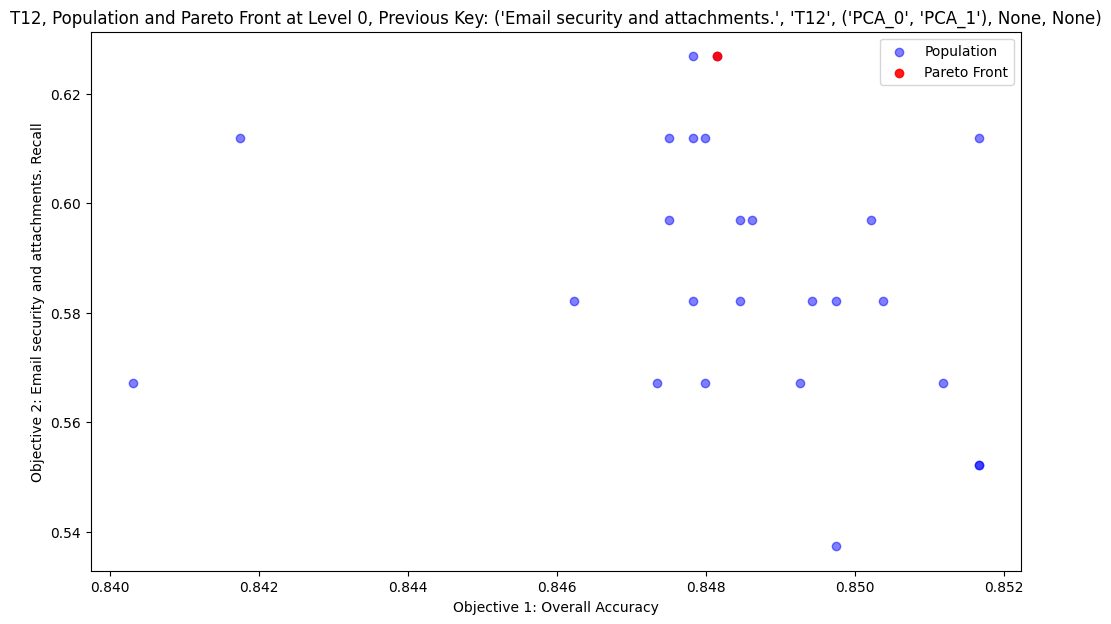

/tmp/ipykernel_49187/2368371630.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  level_stats_df = pd.concat([level_stats_df, new_row_df], ignore_index=True)


CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8414322250639387, 0.582089552238806)
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8495843989769821, 0.6119402985074627)
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.6119402985074627)
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.582089552238806)
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.5970149253731343)
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.5970149253731343)
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.5522388059701493)
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.851502557544757, 0.5970149253731343)
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.582089552238806)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_1.


Level: 1, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_1'), '-0.015209100635731991-0.2051526341726588, -0.13287845406100726-0.02292726417339283', 0), Evaluations: 9
Best Fitness: (0.851502557544757, 0.6119402985074627)
Worst Fitness: (0.8414322250639387, 0.5522388059701493)
Mean Overall Accuracy: 0.8483056265984654
Mean Email security and attachments. Recall: 0.5903814262023217
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731991-0.09497176676846342, -0.09392702450240724--0.016024165385207192, Num Samples 310: [15379, 8293, 21741, 4714, 15736, 17801, 38565, 30448, 13270, 6947, 35189, 30784, 11667, 1215, 31778, 39345, 12567, 29694, 38329, 25367, 37119, 29698, 576, 35418, 29594, 35158, 13129, 1060, 4935, 20472, 5211, 5679, 4934, 33050, 331, 33035, 20062, 924, 27936, 33490, 22046, 32758, 12162, 3620, 5563, 2774, 28951, 32947, 17670, 33321, 31041, 4860, 3367, 8694, 37120, 18606, 414, 1373, 12429, 3480, 18966, 35799] 
Fitness: (0.84958439

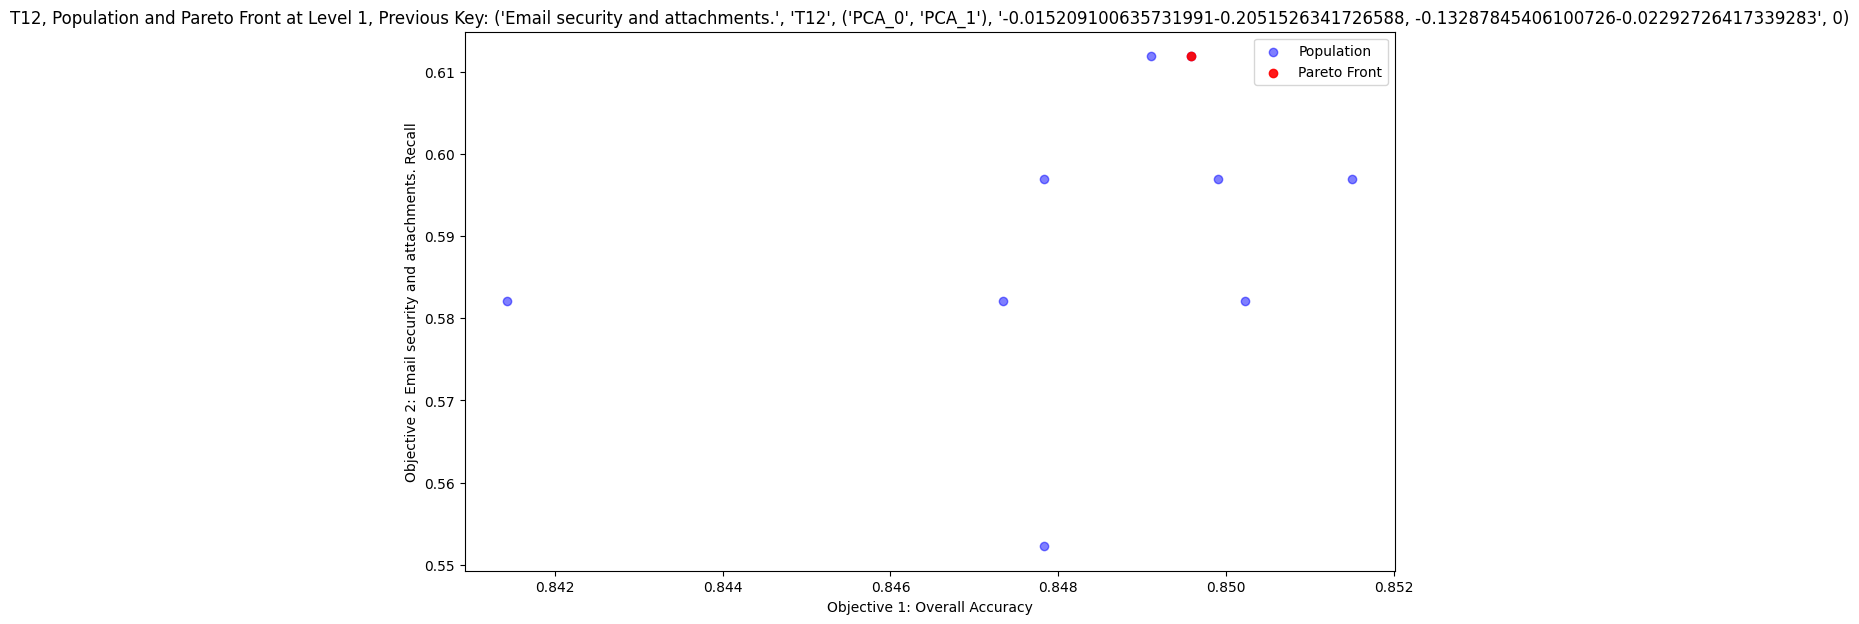

CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.8511828644501279, 0.582089552238806)
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.582089552238806)
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.845108695652174, 0.6119402985074627)
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.5970149253731343)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_1.


Level: 2, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_1'), '-0.015209100635731991-0.09497176676846342, -0.09392702450240724--0.016024165385207192', 1), Evaluations: 4
Best Fitness: (0.8511828644501279, 0.6119402985074627)
Worst Fitness: (0.845108695652174, 0.582089552238806)
Mean Overall Accuracy: 0.8472666240409208
Mean Email security and attachments. Recall: 0.5932835820895522
Pareto Front Selections:---------------------
Segment 1: 0.039881333066365716-0.09497176676846342, -0.09392702450240724--0.054975594943807216, Num Samples 25: [15379, 30448, 20472, 20062, 18966] 
Fitness: (0.845108695652174, 0.6119402985074627)
---
------------------------


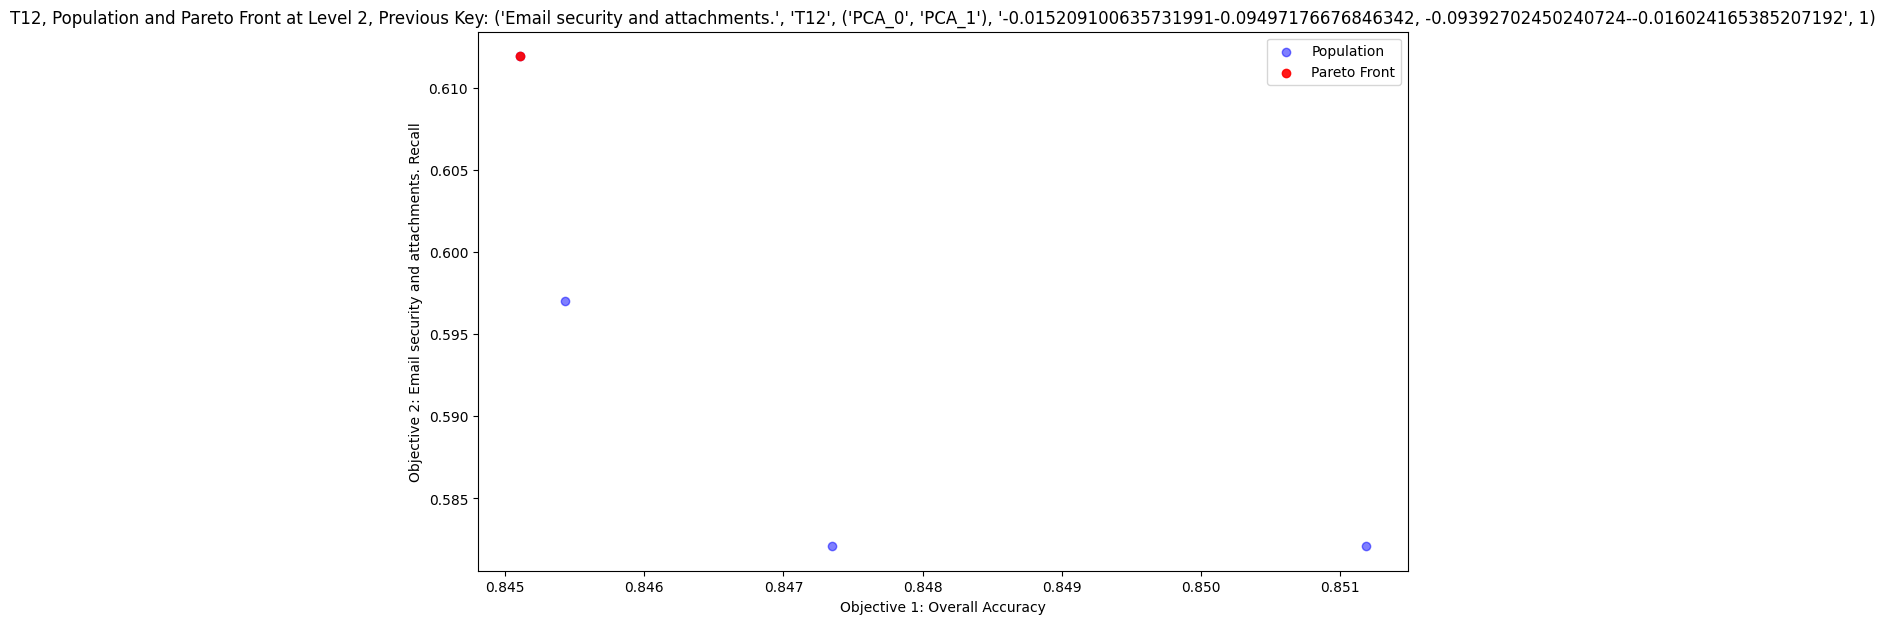

out1
All Pareto Segments in ('PCA_0', 'PCA_1'), Evaluations: 3
Best Fitness: (0.8495843989769821, 0.6268656716417911)
Worst Fitness: (0.845108695652174, 0.6119402985074627)
Mean Overall Accuracy: 0.847612958226769
Mean Email security and attachments. Recall: 0.6169154228855721
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731991-0.2051526341726588, -0.13287845406100726-0.02292726417339283, ('PCA_0', 'PCA_1'), Num Samples 825: [38795, 15379, 8293, 21741, 4714, 37928, 15736, 17801, 38565, 30448, 13270, 35733, 6812, 21656, 6947, 35189, 28853, 30784, 33193, 11667, 6752, 1215, 1096, 18786, 31778, 8294, 25850, 39345, 34681, 3156, 2880, 12567, 29694, 35696, 38329, 25367, 5226, 33423, 29635, 28731, 37119, 29489, 24661, 26447, 24631, 29698, 576, 7404, 35418, 29594, 35158, 17124, 13129, 23155, 1060, 21903, 4935, 13162, 8256, 20472, 3191, 24604, 38590, 5211, 31696, 15021, 28767, 18644, 5679, 4934, 6538, 33050, 23038, 625, 331, 33035, 4699, 10873, 20062, 25027, 924, 3153,

/tmp/ipykernel_49187/833406939.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  level_stats_df_allPCA = pd.concat([level_stats_df_allPCA, level_stats_df], axis=0, ignore_index=True)


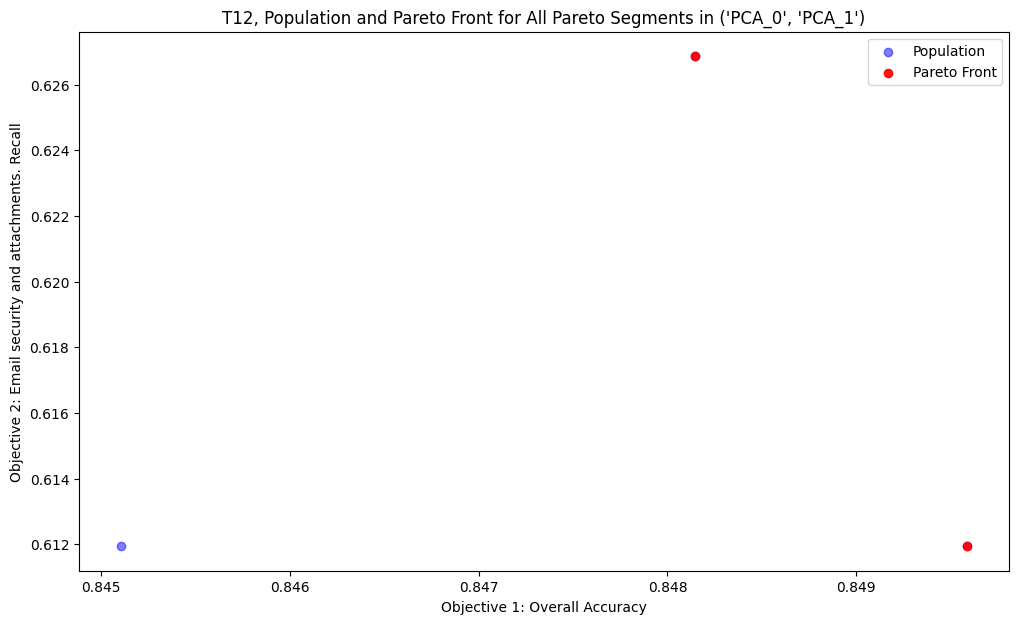

Pair 1 ('PCA_0', 'PCA_2')
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8433503836317136, 0.5970149253731343)
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.6268656716417911)
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.6119402985074627)
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.5522388059701493)
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.582089552238806)
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8507033248081841, 0.6268656716417911)
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8518222506393862, 0.6119402985074627)
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8529411764705882, 0.6119402985074627)
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.5970149253731343)
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.582089552238806)
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.5970149253731343)
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.5970149253731343)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.582089552238806)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.5970149253731343)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.5970149253731343)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.582089552238806)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6119402985074627)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.582089552238806)
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.582089552238806)
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.5671641791044776)
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.5522388059701493)
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.5671641791044776)
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8510230179028133, 0.5522388059701493)
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.5671641791044776)
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.5522388059701493)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_2.


Level: 0, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_2'), None, None), Evaluations: 25
Best Fitness: (0.8529411764705882, 0.6268656716417911)
Worst Fitness: (0.8433503836317136, 0.5522388059701493)
Mean Overall Accuracy: 0.8493797953964194
Mean Email security and attachments. Recall: 0.587462686567164
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731991-0.2051526341726588, -0.17017729102010723--0.04396299300312945, Num Samples 700: [15379, 21741, 4714, 37928, 15736, 17801, 38565, 30448, 35733, 21656, 33437, 6947, 35189, 11667, 6752, 1215, 18786, 31778, 8294, 25850, 39345, 34681, 3156, 2880, 12567, 29694, 9965, 35696, 38329, 25367, 33423, 29635, 28731, 37119, 29489, 24661, 26447, 24631, 29698, 576, 7404, 35418, 29594, 35158, 13129, 23155, 1060, 21903, 4935, 13162, 20472, 24604, 5211, 31696, 15021, 28767, 18644, 5679, 4934, 33050, 23038, 625, 331, 33035, 4699, 10873, 20062, 25027, 924, 3153, 13590, 28271, 21048, 27936, 33490, 22046, 

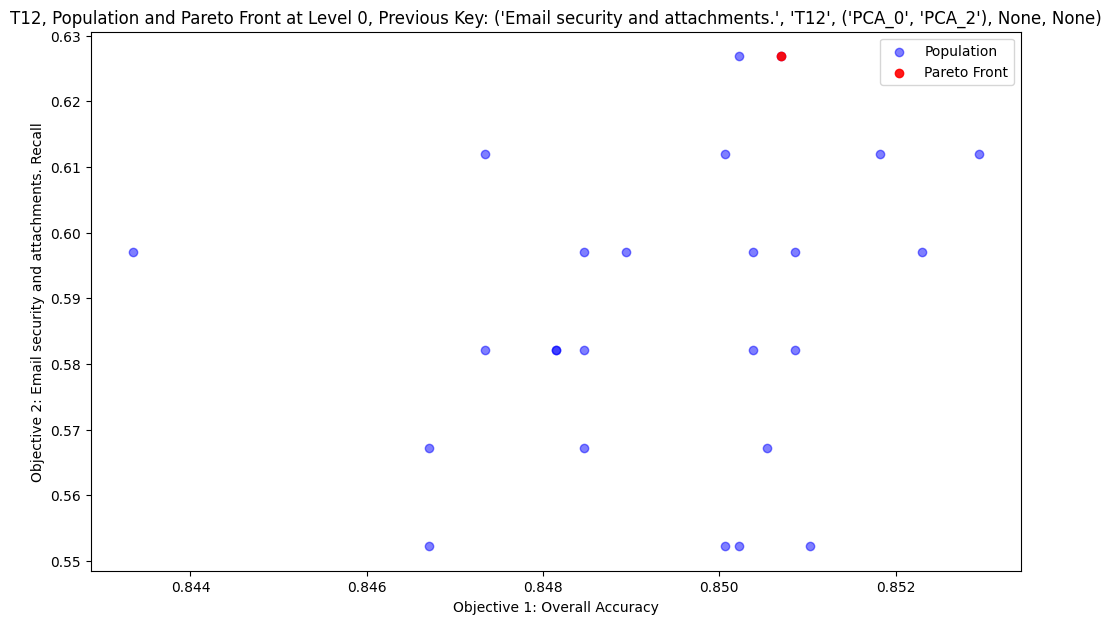

/tmp/ipykernel_49187/2368371630.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  level_stats_df = pd.concat([level_stats_df, new_row_df], ignore_index=True)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8438299232736572, 0.582089552238806)
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.582089552238806)
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.5970149253731343)
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.582089552238806)
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8518222506393862, 0.6119402985074627)
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8519820971867008, 0.6119402985074627)
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.5671641791044776)
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.5970149253731343)
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8510230179028133, 0.5970149253731343)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_2.


Level: 1, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_2'), '-0.015209100635731991-0.2051526341726588, -0.17017729102010723--0.04396299300312945', 0), Evaluations: 9
Best Fitness: (0.8519820971867008, 0.6119402985074627)
Worst Fitness: (0.8438299232736572, 0.5671641791044776)
Mean Overall Accuracy: 0.8491403807899971
Mean Email security and attachments. Recall: 0.5920398009950248
Pareto Front Selections:---------------------
Segment 1: 0.03988133306636571-0.15006220047056112, -0.13862371651586278--0.07551656750737389, Num Samples 210: [15379, 21741, 4714, 15736, 30448, 35733, 35189, 11667, 38329, 25367, 29489, 26447, 1060, 21903, 13162, 20472, 5679, 331, 25027, 924, 21048, 22046, 29563, 3400, 14830, 17110, 17670, 19190, 17451, 4860, 13870, 968, 1413, 3333, 37120, 414, 1373, 22316, 1622, 3480, 35799, 1257] 
Fitness: (0.8518222506393862, 0.6119402985074627)
---
------------------------


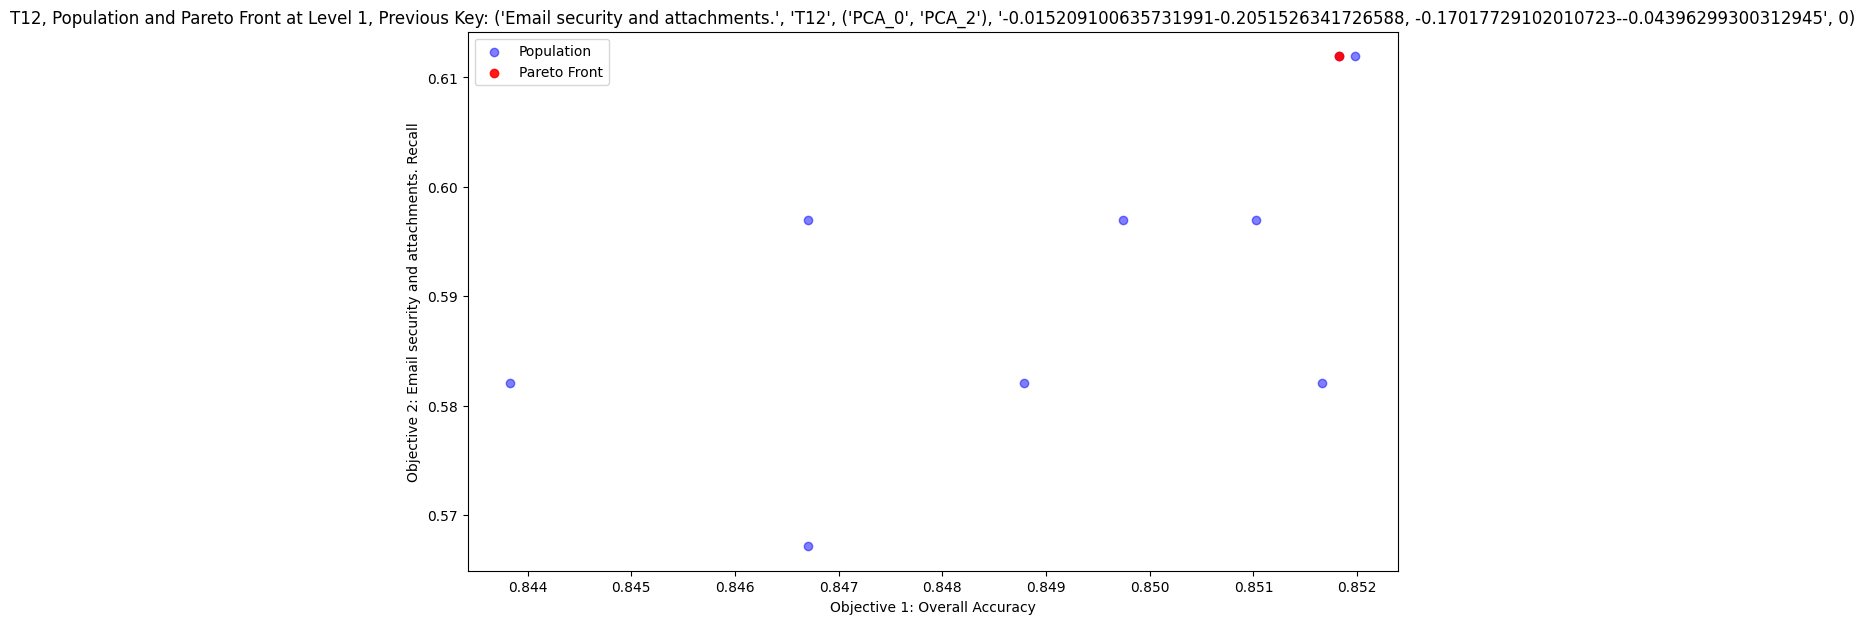

CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.582089552238806)
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.582089552238806)
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
(0.8467071611253197, 0.5671641791044776)
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.5970149253731343)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_2.


Level: 2, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_2'), '0.03988133306636571-0.15006220047056112, -0.13862371651586278--0.07551656750737389', 1), Evaluations: 4
Best Fitness: (0.850383631713555, 0.5970149253731343)
Worst Fitness: (0.8467071611253197, 0.5671641791044776)
Mean Overall Accuracy: 0.8491847826086956
Mean Email security and attachments. Recall: 0.582089552238806
Pareto Front Selections:---------------------
Segment 1: 0.09497176676846342-0.15006220047056112, -0.10707014201161832--0.07551656750737387, Num Samples 50: [29489, 26447, 13162, 21048, 29563, 13870, 968, 1413, 3333, 1257] 
Fitness: (0.8502237851662404, 0.5970149253731343)
---
------------------------


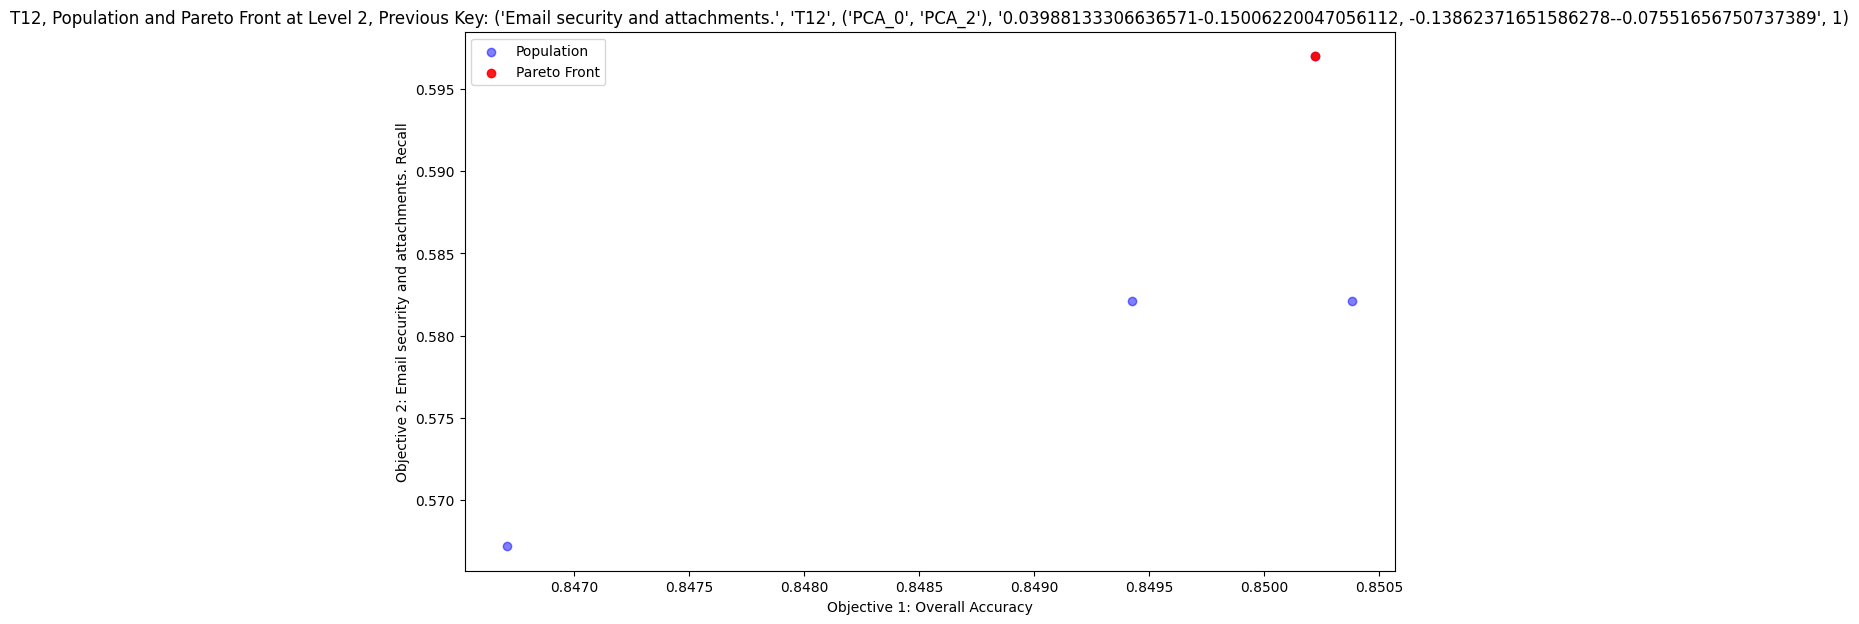

out1
All Pareto Segments in ('PCA_0', 'PCA_2'), Evaluations: 3
Best Fitness: (0.8518222506393862, 0.6268656716417911)
Worst Fitness: (0.8502237851662404, 0.5970149253731343)
Mean Overall Accuracy: 0.8509164535379369
Mean Email security and attachments. Recall: 0.6119402985074627
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731991-0.2051526341726588, -0.17017729102010723--0.04396299300312945, ('PCA_0', 'PCA_2'), Num Samples 700: [15379, 21741, 4714, 37928, 15736, 17801, 38565, 30448, 35733, 21656, 33437, 6947, 35189, 11667, 6752, 1215, 18786, 31778, 8294, 25850, 39345, 34681, 3156, 2880, 12567, 29694, 9965, 35696, 38329, 25367, 33423, 29635, 28731, 37119, 29489, 24661, 26447, 24631, 29698, 576, 7404, 35418, 29594, 35158, 13129, 23155, 1060, 21903, 4935, 13162, 20472, 24604, 5211, 31696, 15021, 28767, 18644, 5679, 4934, 33050, 23038, 625, 331, 33035, 4699, 10873, 20062, 25027, 924, 3153, 13590, 28271, 21048, 27936, 33490, 22046, 6843, 32758, 12162, 29563, 1079,

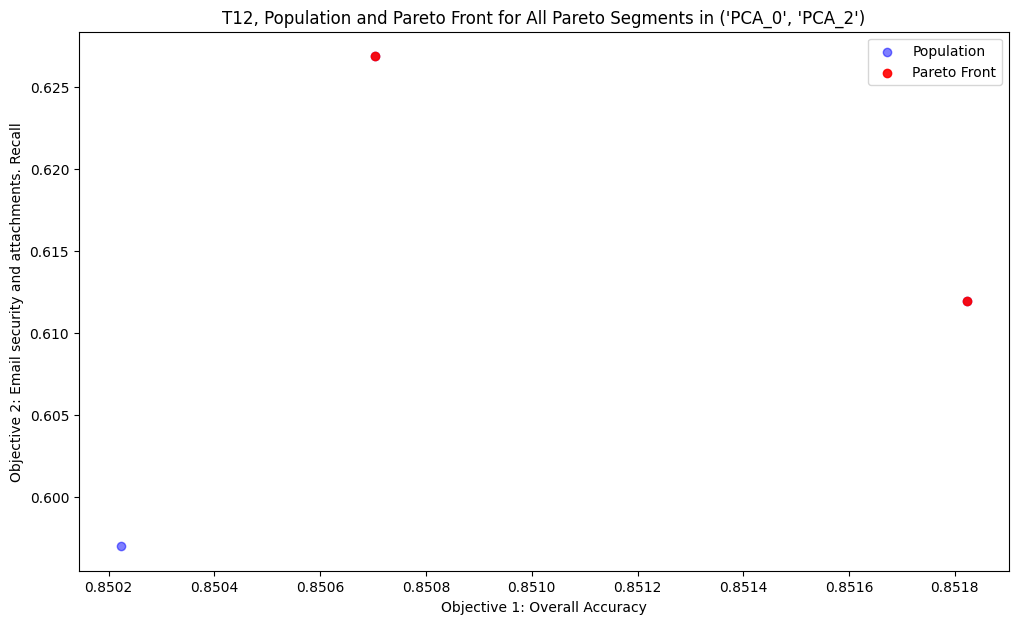

Pair 2 ('PCA_0', 'PCA_3')
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8459079283887468, 0.6119402985074627)
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.6268656716417911)
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8507033248081841, 0.6268656716417911)
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.5970149253731343)
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8459079283887468, 0.5970149253731343)
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8535805626598465, 0.6119402985074627)
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.6119402985074627)
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.6268656716417911)
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.582089552238806)
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.5522388059701493)
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.6119402985074627)
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.6119402985074627)
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.5970149253731343)
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.5970149253731343)
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.5522388059701493)
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.5970149253731343)
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.5671641791044776)
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8529411764705882, 0.5970149253731343)
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.582089552238806)
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.5671641791044776)
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.5970149253731343)
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.5671641791044776)
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8447890025575447, 0.5522388059701493)
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.5522388059701493)
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8526214833759591, 0.5522388059701493)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_3.


Level: 0, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_3'), None, None), Evaluations: 25
Best Fitness: (0.8535805626598465, 0.6268656716417911)
Worst Fitness: (0.8447890025575447, 0.5522388059701493)
Mean Overall Accuracy: 0.8487787723785167
Mean Email security and attachments. Recall: 0.5898507462686566
Pareto Front Selections:---------------------
Segment 1: -0.07029953433782969-0.15006220047056112, -0.16523878857344054-0.04115375987968836, Num Samples 700: [15379, 21741, 4714, 37928, 20968, 15736, 17801, 38565, 13270, 35733, 6812, 21656, 33437, 6947, 35189, 28853, 11667, 6752, 1215, 18786, 31778, 8294, 2773, 25850, 39345, 14141, 34681, 2880, 32693, 29694, 9965, 18585, 35696, 30588, 38329, 25367, 5226, 20662, 33423, 29635, 28731, 15080, 37119, 29489, 24661, 26447, 24631, 29698, 576, 23224, 35418, 35158, 13129, 23155, 1060, 21903, 4935, 13162, 8256, 20472, 3191, 24604, 31696, 15021, 5679, 4934, 33050, 23038, 625, 331, 33035, 4699, 20062, 25027, 924, 3153, 21

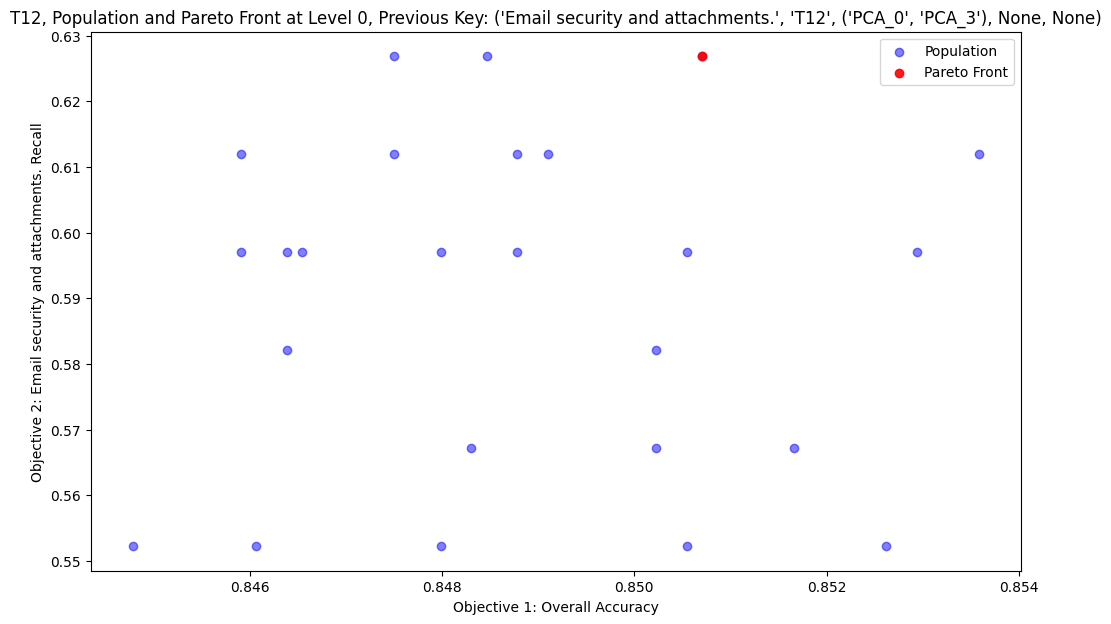

/tmp/ipykernel_49187/2368371630.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  level_stats_df = pd.concat([level_stats_df, new_row_df], ignore_index=True)


CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.582089552238806)
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8524616368286445, 0.5970149253731343)
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8452685421994884, 0.5671641791044776)
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8407928388746803, 0.5970149253731343)
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.5671641791044776)
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8551790281329923, 0.5970149253731343)
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.6119402985074627)
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8527813299232737, 0.582089552238806)
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.5671641791044776)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_3.


Level: 1, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_3'), '-0.07029953433782969-0.15006220047056112, -0.16523878857344054-0.04115375987968836', 0), Evaluations: 9
Best Fitness: (0.8551790281329923, 0.6119402985074627)
Worst Fitness: (0.8407928388746803, 0.5671641791044776)
Mean Overall Accuracy: 0.848909491332765
Mean Email security and attachments. Recall: 0.5854063018242123
Pareto Front Selections:---------------------
Segment 1: 0.03988133306636572-0.15006220047056112, -0.16523878857344054--0.06204251434687609, Num Samples 510: [21741, 4714, 15736, 38565, 13270, 35733, 21656, 35189, 28853, 11667, 18786, 31778, 8294, 25850, 34681, 29694, 38329, 25367, 5226, 33423, 29635, 28731, 29489, 26447, 24631, 13129, 23155, 1060, 21903, 13162, 8256, 20472, 3191, 31696, 15021, 5679, 33050, 23038, 625, 331, 33035, 4699, 20062, 25027, 924, 3153, 21048, 27936, 22046, 6843, 32758, 29563, 3400, 15278, 3375, 15454, 5262, 29097, 11314, 24944, 18263, 14830, 7448, 10800, 28951

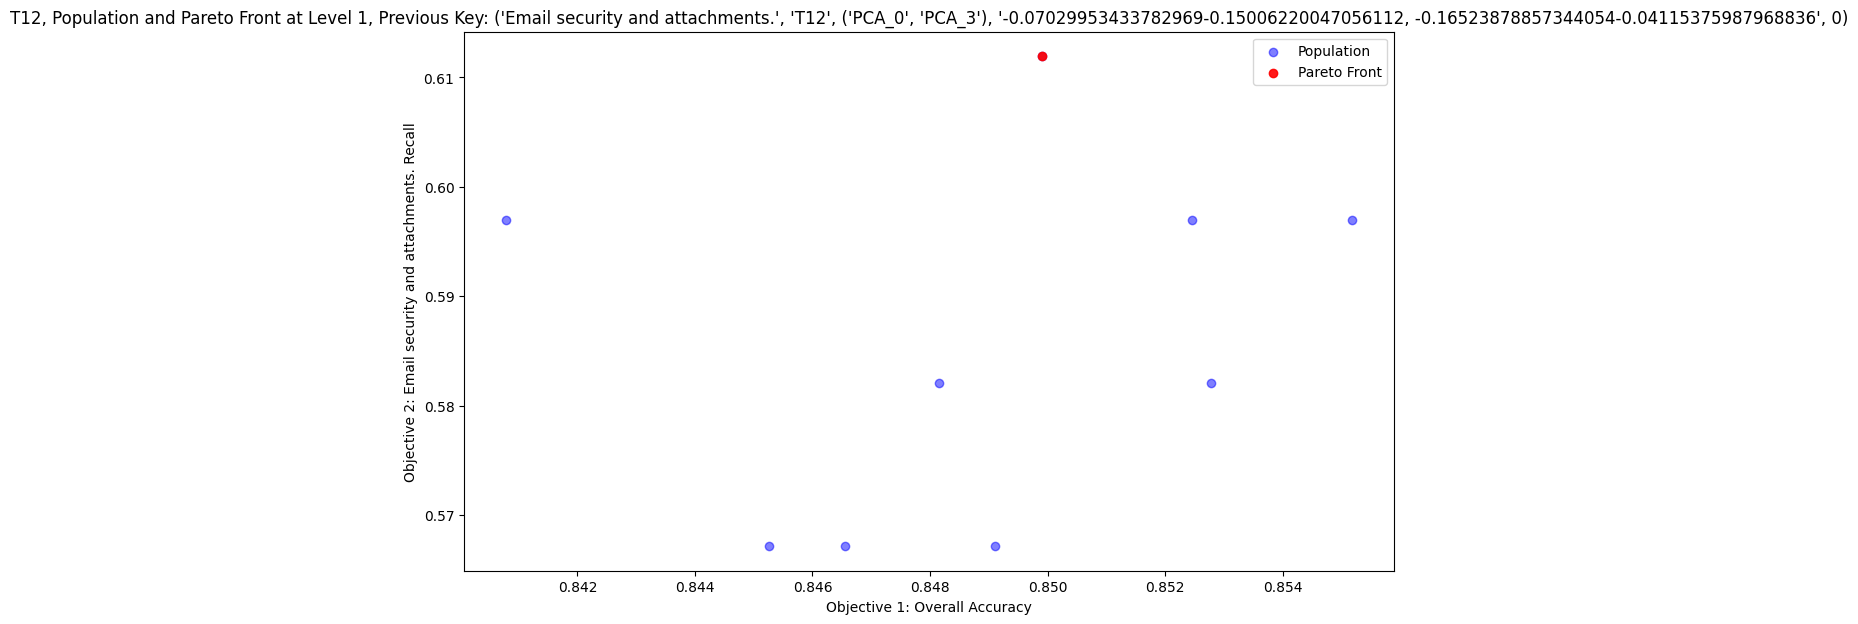

CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.582089552238806)
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8430306905370843, 0.582089552238806)
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.5522388059701493)
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.582089552238806)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_3.


Level: 2, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_3'), '0.03988133306636572-0.15006220047056112, -0.16523878857344054--0.06204251434687609', 1), Evaluations: 4
Best Fitness: (0.8492647058823529, 0.582089552238806)
Worst Fitness: (0.8430306905370843, 0.5522388059701493)
Mean Overall Accuracy: 0.846787084398977
Mean Email security and attachments. Recall: 0.5746268656716418
Pareto Front Selections:---------------------
Segment 1: 0.03988133306636572-0.09497176676846342, -0.16523878857344054--0.11364065146015831, Num Samples 160: [4714, 15736, 38565, 13270, 35189, 11667, 31778, 29694, 25367, 28731, 13129, 1060, 21903, 5679, 331, 25027, 924, 27936, 22046, 10800, 28951, 17110, 17670, 4860, 3367, 37120, 414, 1373, 22316, 12429, 3480, 35799] 
Fitness: (0.8492647058823529, 0.582089552238806)
---
------------------------


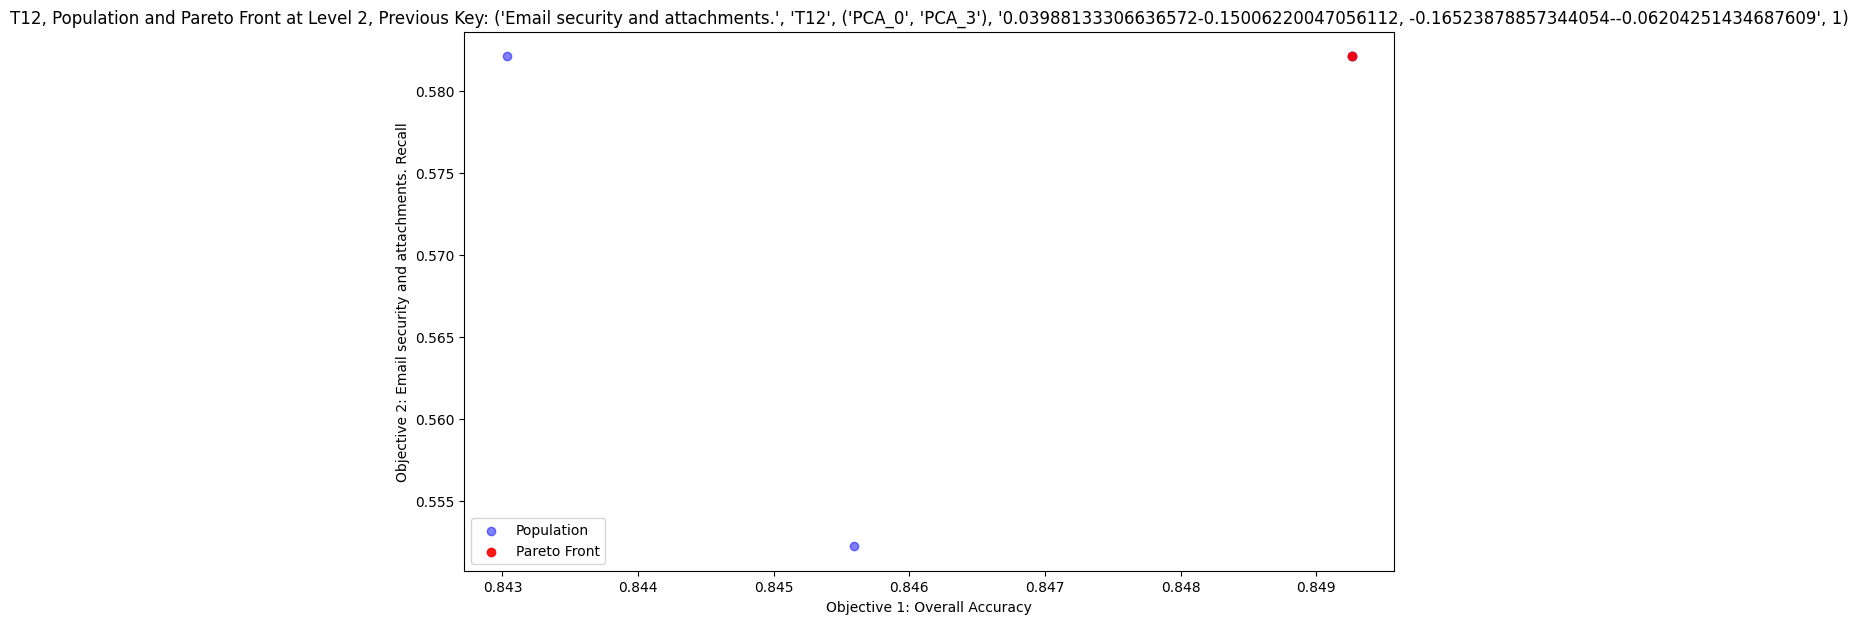

out1
All Pareto Segments in ('PCA_0', 'PCA_3'), Evaluations: 3
Best Fitness: (0.8507033248081841, 0.6268656716417911)
Worst Fitness: (0.8492647058823529, 0.582089552238806)
Mean Overall Accuracy: 0.8499573742540494
Mean Email security and attachments. Recall: 0.6069651741293532
Pareto Front Selections:---------------------
Segment 1: -0.07029953433782969-0.15006220047056112, -0.16523878857344054-0.04115375987968836, ('PCA_0', 'PCA_3'), Num Samples 700: [15379, 21741, 4714, 37928, 20968, 15736, 17801, 38565, 13270, 35733, 6812, 21656, 33437, 6947, 35189, 28853, 11667, 6752, 1215, 18786, 31778, 8294, 2773, 25850, 39345, 14141, 34681, 2880, 32693, 29694, 9965, 18585, 35696, 30588, 38329, 25367, 5226, 20662, 33423, 29635, 28731, 15080, 37119, 29489, 24661, 26447, 24631, 29698, 576, 23224, 35418, 35158, 13129, 23155, 1060, 21903, 4935, 13162, 8256, 20472, 3191, 24604, 31696, 15021, 5679, 4934, 33050, 23038, 625, 331, 33035, 4699, 20062, 25027, 924, 3153, 21048, 27936, 22046, 6843, 32758, 12

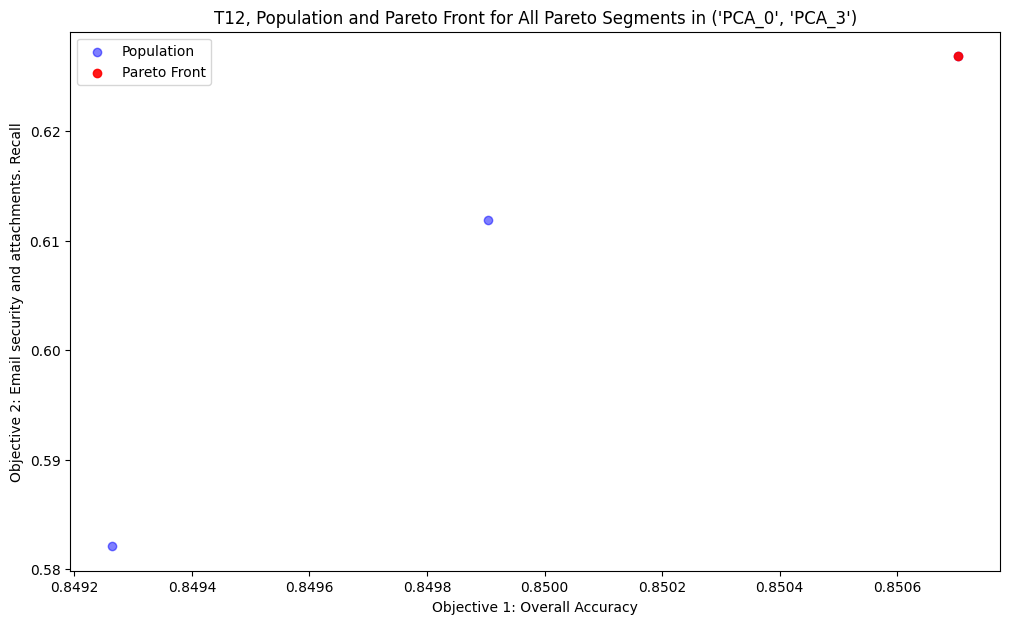

Pair 3 ('PCA_0', 'PCA_4')
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6268656716417911)
CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8526214833759591, 0.6119402985074627)
CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8511828644501279, 0.5970149253731343)
CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.5970149253731343)
CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.582089552238806)
CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.6119402985074627)
CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.6119402985074627)
CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.5970149253731343)
CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.5970149253731343)
CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.582089552238806)
CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8459079283887468, 0.5970149253731343)
CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6119402985074627)
CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.5671641791044776)
CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8535805626598465, 0.5970149253731343)
CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.582089552238806)
CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8507033248081841, 0.582089552238806)
CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.5671641791044776)
CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.582089552238806)
CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.5671641791044776)
CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.5671641791044776)
CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.582089552238806)
CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.5522388059701493)
CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.5522388059701493)
CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8526214833759591, 0.5671641791044776)
CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8526214833759591, 0.5671641791044776)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_4.


Level: 0, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_4'), None, None), Evaluations: 25
Best Fitness: (0.8535805626598465, 0.6268656716417911)
Worst Fitness: (0.8459079283887468, 0.5522388059701493)
Mean Overall Accuracy: 0.8501982097186701
Mean Email security and attachments. Recall: 0.5862686567164179
Pareto Front Selections:---------------------
Segment 1: -0.07029953433782969-0.15006220047056112, -0.18986139761389995-0.004971465355046806, Num Samples 695: [8293, 21741, 4714, 37928, 15736, 17801, 38565, 30448, 13270, 35733, 6812, 21656, 6947, 35189, 28853, 30784, 11667, 1215, 18786, 31778, 8294, 25850, 39345, 14141, 34681, 3156, 2880, 32693, 12567, 29694, 9965, 18585, 35696, 30588, 38329, 5226, 20662, 33423, 29635, 28731, 15080, 28883, 37119, 29489, 24661, 26447, 24631, 29698, 576, 35418, 29594, 35158, 13129, 23155, 1060, 21903, 4935, 13162, 8256, 20472, 3191, 24604, 5211, 31696, 15021, 5679, 4934, 33050, 23038, 625, 331, 33035, 4699, 25027, 924, 3153, 21

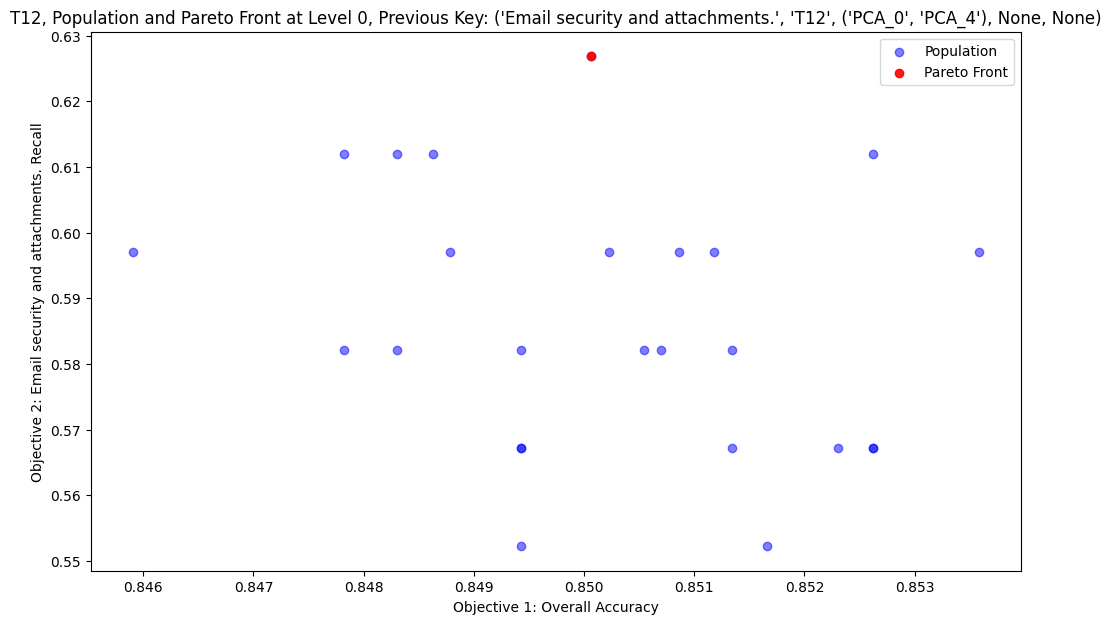

/tmp/ipykernel_49187/2368371630.py:294: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  level_stats_df = pd.concat([level_stats_df, new_row_df], ignore_index=True)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.844309462915601, 0.582089552238806)
CPU Current memory usage: 4.2%
Current GPU memory usage: 2.36%


(0.8495843989769821, 0.5671641791044776)
CPU Current memory usage: 4.2%
Current GPU memory usage: 2.36%


(0.8521419437340153, 0.582089552238806)
CPU Current memory usage: 4.2%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.5970149253731343)
CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.5970149253731343)
CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.582089552238806)
CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5970149253731343)
CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.582089552238806)
CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.854539641943734, 0.5970149253731343)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_4.


Level: 1, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_4'), '-0.07029953433782969-0.15006220047056112, -0.18986139761389995-0.004971465355046806', 0), Evaluations: 9
Best Fitness: (0.854539641943734, 0.5970149253731343)
Worst Fitness: (0.844309462915601, 0.5671641791044776)
Mean Overall Accuracy: 0.8487318840579711
Mean Email security and attachments. Recall: 0.5870646766169154
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731984-0.09497176676846343, -0.18986139761389995--0.09244496612942657, Num Samples 110: [21741, 15736, 30448, 35733, 25850, 3156, 2880, 9965, 35696, 28731, 24631, 21903, 24604, 31696, 25027, 33490, 17110, 9680, 37120, 414, 22316, 35799] 
Fitness: (0.8497442455242967, 0.5970149253731343)
---
------------------------


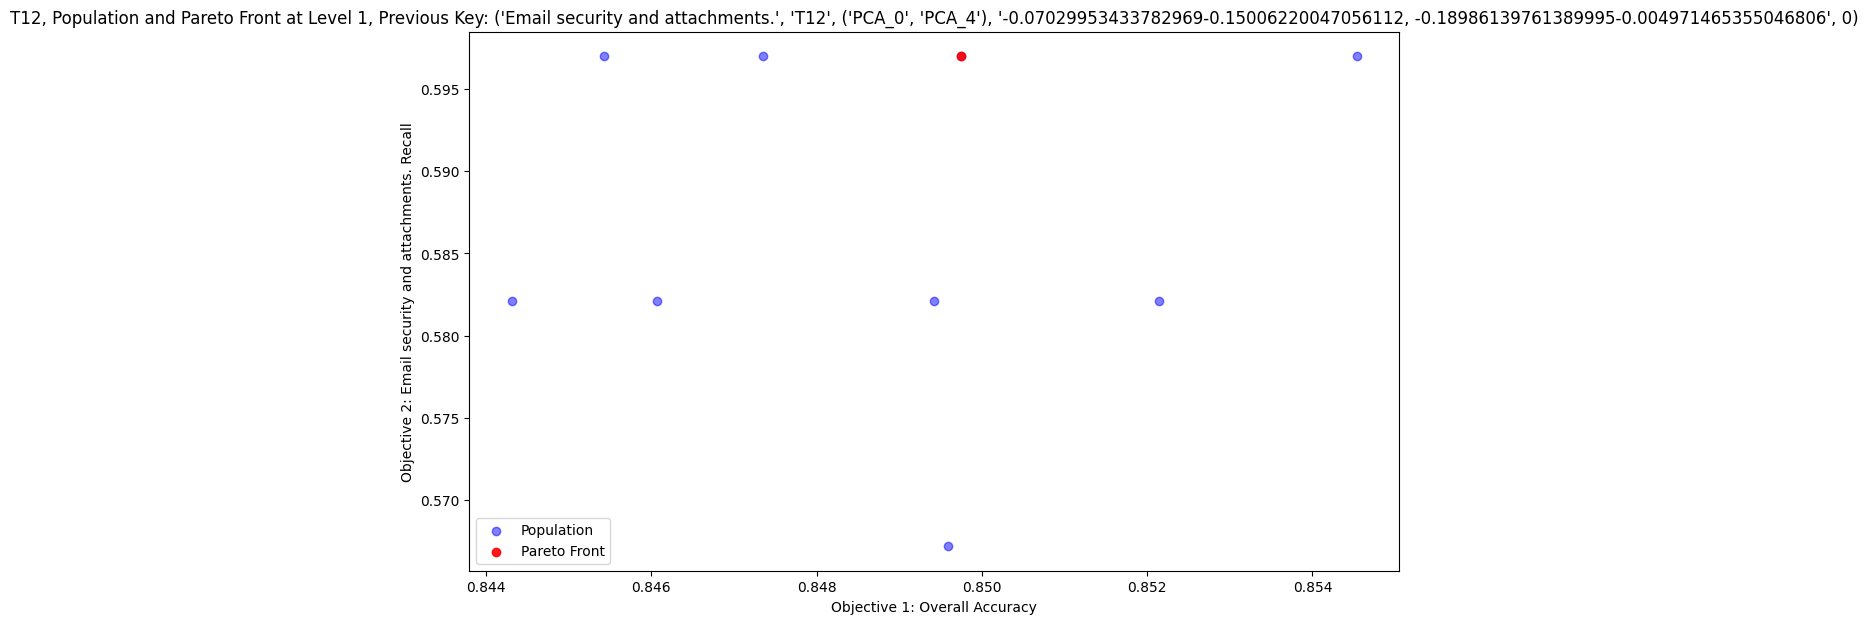

CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.582089552238806)
CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8452685421994884, 0.5671641791044776)
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.582089552238806)
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.582089552238806)
Finished hierarchical sliding window for Email security and attachments._PCA_0_PCA_4.


Level: 2, Previous Key: ('Email security and attachments.', 'T12', ('PCA_0', 'PCA_4'), '-0.015209100635731984-0.09497176676846343, -0.18986139761389995--0.09244496612942657', 1), Evaluations: 4
Best Fitness: (0.8508631713554987, 0.582089552238806)
Worst Fitness: (0.8452685421994884, 0.5671641791044776)
Mean Overall Accuracy: 0.8483455882352942
Mean Email security and attachments. Recall: 0.5783582089552239
Pareto Front Selections:---------------------
Segment 1: -0.015209100635731984-0.03988133306636572, -0.18986139761389995--0.14115318187166326, Num Samples 5: [24604] 
Fitness: (0.8508631713554987, 0.582089552238806)
---
Segment 2: 0.03988133306636572-0.09497176676846343, -0.18986139761389995--0.14115318187166326, Num Samples 15: [30448, 31696, 25027] 
Fitness: (0.8467071611253197, 0.582089552238806)
---
------------------------


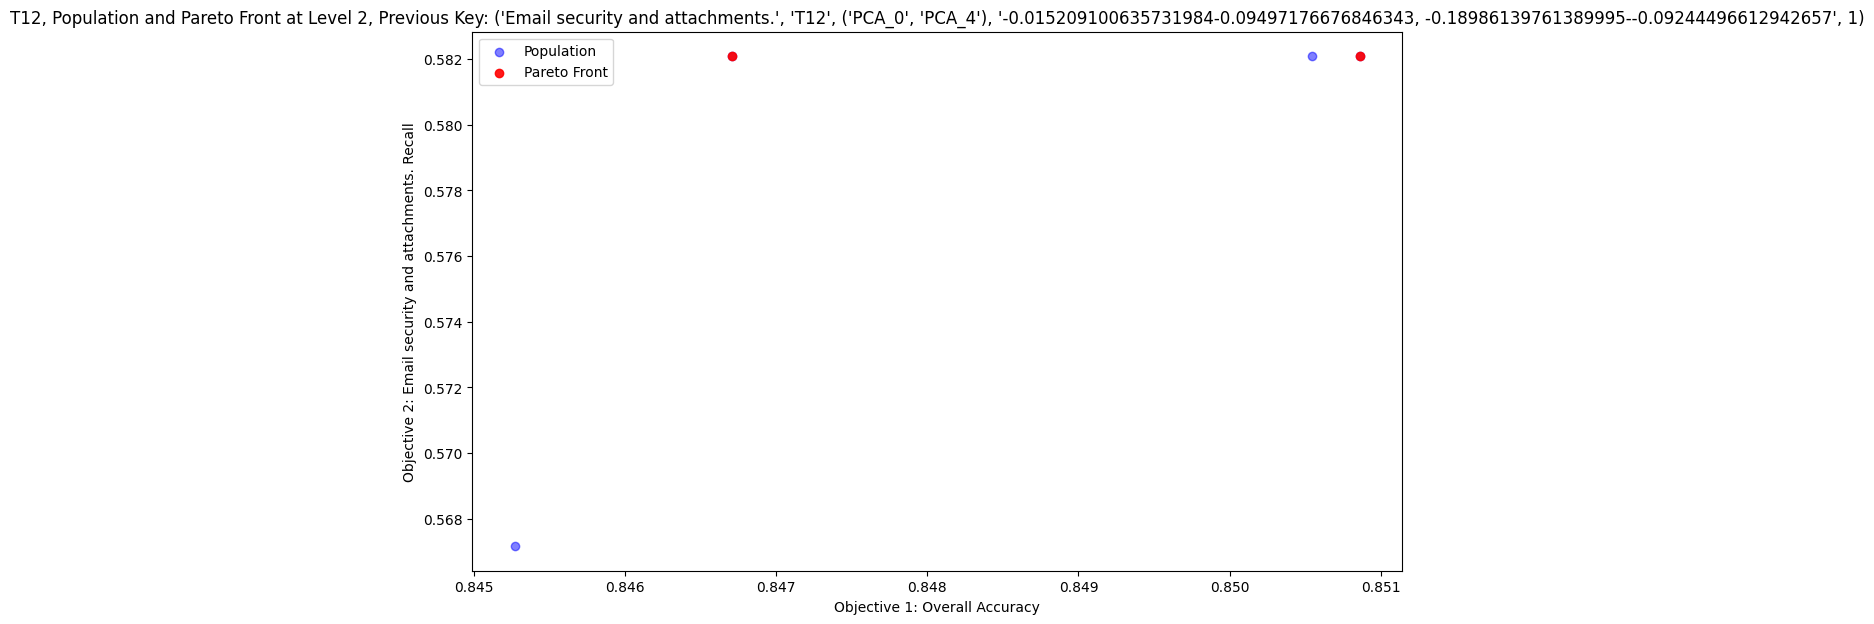

out1
All Pareto Segments in ('PCA_0', 'PCA_4'), Evaluations: 4
Best Fitness: (0.8508631713554987, 0.6268656716417911)
Worst Fitness: (0.8467071611253197, 0.582089552238806)
Mean Overall Accuracy: 0.8493446291560102
Mean Email security and attachments. Recall: 0.5970149253731344
Pareto Front Selections:---------------------
Segment 1: -0.07029953433782969-0.15006220047056112, -0.18986139761389995-0.004971465355046806, ('PCA_0', 'PCA_4'), Num Samples 695: [8293, 21741, 4714, 37928, 15736, 17801, 38565, 30448, 13270, 35733, 6812, 21656, 6947, 35189, 28853, 30784, 11667, 1215, 18786, 31778, 8294, 25850, 39345, 14141, 34681, 3156, 2880, 32693, 12567, 29694, 9965, 18585, 35696, 30588, 38329, 5226, 20662, 33423, 29635, 28731, 15080, 28883, 37119, 29489, 24661, 26447, 24631, 29698, 576, 35418, 29594, 35158, 13129, 23155, 1060, 21903, 4935, 13162, 8256, 20472, 3191, 24604, 5211, 31696, 15021, 5679, 4934, 33050, 23038, 625, 331, 33035, 4699, 25027, 924, 3153, 21048, 27936, 33490, 22046, 6843, 32

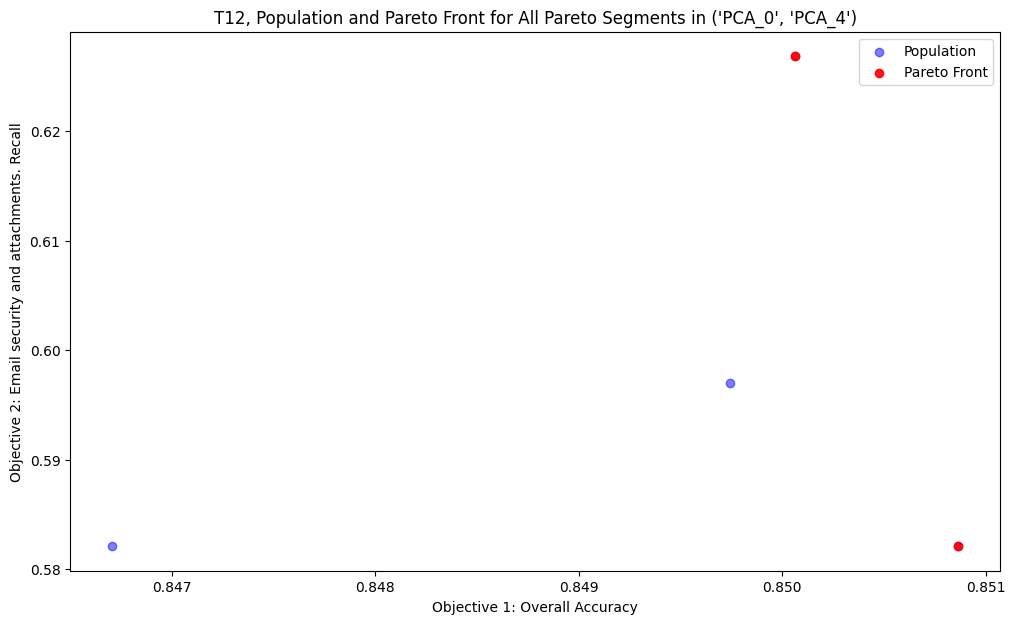

Pair 4 ('PCA_0', 'PCA_5')
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.5970149253731343)
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.5970149253731343)
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8462276214833759, 0.5970149253731343)
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8441496163682864, 0.6119402985074627)
CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.6119402985074627)
CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.5671641791044776)
CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.8507033248081841, 0.582089552238806)
CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.6119402985074627)
CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.6119402985074627)
CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8439897698209718, 0.6119402985074627)
CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.5522388059701493)
CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.582089552238806)
CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.6119402985074627)
CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8510230179028133, 0.5671641791044776)
CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.5970149253731343)
CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.582089552238806)
CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.582089552238806)
CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.5671641791044776)
CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.844309462915601, 0.5671641791044776)
CPU Current memory usage: 4.8%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.5671641791044776)
CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.5671641791044776)
CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.5671641791044776)
Terminating due to GPU training time
All objectives are None or 0, skipping further processes.


/tmp/ipykernel_49187/833406939.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  level_stats_df_allPCA = pd.concat([level_stats_df_allPCA, level_stats_df], axis=0, ignore_index=True)


                                          precision    recall  f1-score  \
IT support and assistance.                 0.981945  0.964531  0.973160   
Account activation and access issues.      0.904412  0.925631  0.914898   
Password and device security.              0.910560  0.911543  0.911051   
Printer issues and troubleshooting.        0.901186  0.811388  0.853933   
HP Dock connectivity issues.               0.780718  0.774859  0.777778   
Employee documentation and errors.         0.570156  0.686327  0.622871   
"Access and login issues"                  0.709751  0.792405  0.748804   
Opening and managing files/devices.        0.658333  0.669492  0.663866   
Mobile email and VPN setup.                0.609610  0.730216  0.664484   
IT support and communication.              0.567114  0.504478  0.533965   
Error handling in RPG programming.         1.000000  0.946809  0.972678   
Email security and attachments.            0.722222  0.609375  0.661017   
Humanitarian aid for Ukra

In [7]:
if __name__ == "__main__":
    run = 1
    rand = 10

    t12_cr_imp_max = 0
    
    run_path = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}"
    itr0_path = f"{run_path}/Iteration_0"
    os.makedirs(itr0_path, exist_ok=True)

    # Load Data
    data = pd.read_csv(f'D:/AutoGeTS/Data/tickets_topics.csv',lineterminator='\n')
    data_topic = data.dropna().reset_index()
    data_topic = data_topic.rename(columns={'index': 'index_meta'})

    X_train_r_both, X_test_re_Test, Y_train_r_both, Y_test_re_Test = train_test_split(data_topic, data_topic.topic_name, test_size = 0.2,random_state = 42)
        
    # Further split the training set to create a validation set
    X_train_r, X_test_re, Y_train_r, Y_test_re = train_test_split(
        X_train_r_both, 
        Y_train_r_both, 
        test_size=0.2,  # 20% of the initial training set, which is 16% of the original data
        random_state=rand
    )

    catboost_params = {'iterations': 300, 'learning_rate': 0.2, 'depth': 8, 'l2_leaf_reg': 1, 
                        'bagging_temperature': 1, 'random_strength': 1, 'border_count': 254, 
                        'eval_metric': 'TotalF1', 'task_type': 'GPU', 'early_stopping_rounds': 20, 'use_best_model': True, 'verbose': 0, 'random_seed': rand}

    bch_dict = train_bch(X_train_r, X_test_re, Y_train_r, Y_test_re, catboost_params, itr0_path)
    for iteration in [1]:
        if iteration == 1:
            topic_number = "T12"
        # for topic_number in ["T13"]: # "T1", "T2", "T4", "T5", "T10", "T13", "T14" 
        # iteration = 2
        prev_itr = iteration - 1

        gpu_hours = 1

        if topic_number in ["T1", "T5", "T10"]:
            metric_name = "overall_f1-score" # "recall", "Balanced Accuracy", "overall_balanced_accuracy", "overall_f1-score"
        elif topic_number in ["T2"]:
            metric_name = "recall"
        elif topic_number in ["T12"]:
            metric_name = "Balanced Accuracy"
        elif topic_number in ["T4", "T14"]:
            metric_name = "overall_balanced_accuracy"

        HSW_results_path = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/{topic_number}_{metric_name}_GPU{gpu_hours}h_HSW"
        os.makedirs(HSW_results_path, exist_ok=True)
        
        """Results region"""
        fold_results_df = pd.DataFrame() # pd.read_pickle("D:/AutoGeTS/Topic_Experiments/Hierarchical-SW_Results/HSWAllSegs_HSW_T13_ModeBoth_as=T,o,p,i,c,M,i,n,M,a,x_ns=8,4,2_ws=h,a,l,f_PCA_0PCA_1_PCA_18PCA_19.pkl") # pd.DataFrame()  # DataFrame to collect aggregated results
        fold_pfs_df = pd.DataFrame()  # DataFrame to collect details from each fold
        pca_pfs_df = pd.DataFrame() # pd.read_pickle("D:/AutoGeTS/Topic_Experiments/Hierarchical-SW_Results/HSWpcaPFs_HSW_T13_ModeBoth_as=T,o,p,i,c,M,i,n,M,a,x_ns=8,4,2_ws=h,a,l,f_PCA_0PCA_1_PCA_18PCA_19.pkl") # pd.DataFrame()
        test_fold_results_df = pd.DataFrame()

        history_segments_dict_allPCA = {}
        history_pareto_segments_list = []
        level_stats_df_allPCA = pd.DataFrame(columns=["PCA", "Level", "Previous Key", "Number of Evaluations", "Best Fitness", "Worst Fitness", "Mean Overall Accuracy", "Mean Topic Recall", "Pareto Front Segments"])

        if iteration > 1:
            bch_class_df = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/Bch_Itr_{prev_itr}.pkl")
            bch_filtered_columns = [col for col in bch_class_df.columns if not col.startswith("Diff") and col != "Accuracy"]
            bch_class_df = bch_class_df[bch_filtered_columns]
        else:
            bch_class_df = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_0/Benchmark_M0_Classdf_0.pkl")

        bch_m0 = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_0/Benchmark_M0_Classdf_0.pkl")
        
        if iteration > 1:
            prev_itr_X_train_re = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/X_train_re_itr_{prev_itr}.pkl")
            X_train_r = prev_itr_X_train_re
            prev_itr_Y_train_re = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/Y_train_re_itr_{prev_itr}.pkl")
            Y_train_r = prev_itr_Y_train_re

        # Get the set of 'index_meta' values from X_train_r
        index_meta_values = X_train_r['index_meta'].unique()
        train_PCA_YZ_df = pd.read_pickle("D:/AutoGeTS/Data/Train_PCA_YZ_withPred_0.pkl")
        train_PCA_YZ_df = train_PCA_YZ_df[train_PCA_YZ_df['index_meta'].isin(index_meta_values)]
        # train_PCA_YZ_df = train_PCA_YZ_df.rename(columns={'index': 'index_meta'})
        pca_columns = [col for col in train_PCA_YZ_df.columns if 'PCA_' in col]
        pca_pairs = list(itertools.combinations(pca_columns, 2))

        topic_dict = {"T1": "IT support and assistance.","T2": "Account activation and access issues.","T3": "Password and device security.",
                    "T4": "Printer issues and troubleshooting.","T5": "HP Dock connectivity issues.","T6": "Employee documentation and errors.",
                    "T7": "\"Access and login issues\"","T8": "Opening and managing files/devices.","T9": "Mobile email and VPN setup.",
                    "T10": "IT support and communication.","T11": "Error handling in RPG programming.","T12": "Email security and attachments.",
                    "T13": "Humanitarian aid for Ukraine.","T14": "Internet connectivity issues in offices.","T15": "Improving integration with Infojobs."}

        """Parameters and Input Section ----------------"""
        # topic_number = "T13"
        syn_number = 1

        dots_mode = "Both"

        total_gpu_seconds = gpu_hours * 60 * 60
        
        # Added synthetic data path
        if topic_number in ["T1", "T2"]:
            data_syn_raw = pd.read_pickle(f'D:/AutoGeTS/Synthetic_Data/{topic_number}-synthesis-{syn_number}.pkl')
        else:
            data_syn_raw = pd.read_csv(f'D:/AutoGeTS/Synthetic_Data/{topic_number}-synthesis-{syn_number}.csv',lineterminator='\n')
        data_syn = data_syn_raw[["index_meta", "text", "area_TEIS", 'topic_name', "sample"]].dropna()

        hsw_param_dict = {'area_size': "TopicMinMax",
                    'num_segments': [8, 4, 2],
                    'window_size': "half"
                    }

        # level_0_pca_pairs = pca_pairs # pca_pairs, [("PCA_1", "PCA_13")]
        pca_pairs_used = pca_pairs

        history_dict_name = f"HSW-Retrain-Dict_{topic_number}_Mode{dots_mode}_{dict_to_foldername(hsw_param_dict)}_{''.join(item for item in pca_pairs_used[0])}_{''.join(item for item in pca_pairs_used[-1])}"
        level_stats_df_name = f"HSW-Level-Stats_{topic_number}_Mode{dots_mode}_{dict_to_foldername(hsw_param_dict)}_{''.join(item for item in pca_pairs_used[0])}_{''.join(item for item in pca_pairs_used[-1])}"
        HSW_results_name = f"HSW_{topic_number}_Mode{dots_mode}_{dict_to_foldername(hsw_param_dict)}_{''.join(item for item in pca_pairs_used[0])}_{''.join(item for item in pca_pairs_used[-1])}"

        """------------------------------------------------"""
        topic_name = topic_dict[topic_number]
        clean_topic_name = clean_folder_name(topic_name)

        sum_GPU_seconds = 0
        GPU_limit = False

        for pca_i, pca_pair in enumerate(pca_pairs):
            # if pca_i <= 153:
            #     continue
            print(f"Pair {pca_i}", pca_pair)
            CPU_monitor_memory_usage()
            monitor_gpu_memory()

            level_0_pca_pairs = [pca_pair]

            history_segments_dict = {}
            level_stats_df = pd.DataFrame(columns=["PCA", "Level", "Previous Key", "Number of Evaluations", "Best Fitness", "Worst Fitness", "Mean Overall Accuracy", "Mean Topic Recall", "Pareto Front Segments"])

            if hsw_param_dict['area_size'] == "FullSize":
                level_0_area_size_x = "FullSize"
                level_0_area_size_y = "FullSize"
                level_0_x_start = "minimum"
                level_0_y_start = "minimum"
            elif hsw_param_dict['area_size'] == "TopicMinMax":
                filtered_df = train_PCA_YZ_df[train_PCA_YZ_df['topic_name'] == topic_name]
                level_0_area_size_x =(filtered_df[pca_pair[0]].min()*1.01, filtered_df[pca_pair[0]].max()*1.01)
                level_0_area_size_y =(filtered_df[pca_pair[1]].min()*1.01, filtered_df[pca_pair[1]].max()*1.01)
                level_0_x_start = level_0_area_size_x[0] 
                level_0_y_start = level_0_area_size_y[0]
            else:
                level_0_area_size_x = hsw_param_dict['area_size']
                level_0_area_size_y = hsw_param_dict['area_size']
                level_0_x_start = level_0_area_size_x[0]
                level_0_y_start = level_0_area_size_y[0]
            levels_num_segments_list = hsw_param_dict['num_segments']
            if hsw_param_dict['window_size'] == "half":
                levels_window_size_list = [int(item / 2) for item in levels_num_segments_list]
            else:
                levels_window_size_list = [int(hsw_param_dict['window_size']) for item in levels_num_segments_list]

            history_segments_dict = hierarchical_sliding_window_retrain(history_segments_dict, train_PCA_YZ_df, data_syn, topic_name, topic_number, level_0_area_size_x, level_0_area_size_y, level_0_x_start,  level_0_y_start, level_0_pca_pairs, levels_num_segments_list, levels_window_size_list)
            history_segments_dict_allPCA.update(history_segments_dict)
            # with open(f'{HSW_results_path}/{history_dict_name}_AllPCADictsList.pkl', 'wb') as file:
            #     pickle.dump(history_segments_dict_allPCA, file)
            
            level_stats_df_allPCA = pd.concat([level_stats_df_allPCA, level_stats_df], axis=0, ignore_index=True)
            level_stats_df_allPCA.to_csv(f'{HSW_results_path}/{level_stats_df_name}.csv', index=False)
            level_stats_df_allPCA.to_pickle(f'{HSW_results_path}/{level_stats_df_name}.pkl')

            pca_pareto_observer(history_pareto_segments_list, pca_pair)

            if GPU_limit == True:
                fold_results_df  = find_pareto_front(fold_results_df)
                fold_results_df = find_best_values(fold_results_df)
                fold_results_df = post_process(fold_results_df, bch_class_df)
                fold_results_df.to_csv(f'{HSW_results_path}/HSWAllSegs_{HSW_results_name}.csv', index=False)
                fold_results_df.to_pickle(f'{HSW_results_path}/HSWAllSegs_{HSW_results_name}.pkl')
                # break
                test_fold_results_df  = find_pareto_front(test_fold_results_df)
                test_fold_results_df = find_best_values(test_fold_results_df)
                test_fold_results_df = post_process(test_fold_results_df, bch_class_df)
                test_fold_results_df.to_csv(f'{HSW_results_path}/test_HSWAllSegs_{HSW_results_name}.csv', index=True)
                test_fold_results_df.to_pickle(f'{HSW_results_path}/test_HSWAllSegs_{HSW_results_name}.pkl')
                break
        
        iteration_repo = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/"
        no_improve_repo = os.path.join(iteration_repo, "Itr_No_Improve")

        os.makedirs(iteration_repo, exist_ok=True)  # Always need iteration_repo
        
        def store_classification_df(df, repo_path, iteration):
            """Helper to store classification DataFrame in CSV/PKL format."""
            csv_path = os.path.join(repo_path, f"Bch_Itr_{iteration}.csv")
            pkl_path = os.path.join(repo_path, f"Bch_Itr_{iteration}.pkl")
            df.to_csv(csv_path, index=True)
            df.to_pickle(pkl_path)

        def store_xy_data(X, Y, repo_path, iteration):
            """Helper to store X_train_re/Y_train_re in PKL format."""
            X_path = os.path.join(repo_path, f"X_train_re_itr_{iteration}.pkl")
            Y_path = os.path.join(repo_path, f"Y_train_re_itr_{iteration}.pkl")
            X.to_pickle(X_path)
            Y.to_pickle(Y_path)
            
        """Extract best model and append synthetics"""
        # Find the index of the row with the largest value in the 'max_overall_balanced_acc_imp' column
        # index_of_max_imp = test_fold_results_df['T12_CR_Imp'].idxmax()
        
        # print(index_of_max_imp)

        # # Retrieve the row corresponding to this index
        # row_with_largest_value = test_fold_results_df.loc[index_of_max_imp]

        constrained_df = test_fold_results_df[
            (test_fold_results_df['T12_CR_Imp'] >= 0) & 
            (test_fold_results_df['T7_CR_Imp'] >= 0) & 
            (test_fold_results_df['OF1_Imp'] >= 0)
        ]

        if constrained_df.empty:
            # Create the "constrained_df_empty" folder
            empty_folder_path = os.path.join(iteration_repo, "constrained_df_empty")
            os.makedirs(empty_folder_path, exist_ok=True)
            
            # If there's no row that satisfies the requirement,
            # then we do the "no improvement" logic:
            store_classification_df(bch_class_df, iteration_repo, iteration)
            store_xy_data(prev_itr_X_train_re, prev_itr_Y_train_re, iteration_repo, iteration)

            with open(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/T12_CR_imp_max.pkl", "wb") as file:
                pickle.dump(t12_cr_imp_max, file)

        else:
            # Sort descending by T12_CR_Imp, then topic_balanced_accuracy, then overall_balanced_accuracy
            sorted_df = constrained_df.sort_values(
                by=["Super_Obj_T12T7_CR", "T12_CR_Imp", "Super_Obj_T12T7_CBA", "overall_balanced_accuracy"],
                ascending=False
            )

            # Pick the first row from the sorted DataFrame
            row_with_largest_value = sorted_df.iloc[0]

            largest_value = row_with_largest_value["T12_CR_Imp"]
            if t12_cr_imp_max < largest_value:
                t12_cr_imp_max = largest_value
            
            with open(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/T12_CR_imp_max.pkl", "wb") as file:
                pickle.dump(t12_cr_imp_max, file)

            filtered_syn_df = data_syn[data_syn['index_meta'].isin(row_with_largest_value['retrained_dots_list'])]

            X_train_re = pd.concat([X_train_r, filtered_syn_df.drop(columns=['topic_name'])])
            Y_train_re = pd.concat([Y_train_r, filtered_syn_df['topic_name']])

            train_pool_re = Pool(
                X_train_re[["text", "area_TEIS"]],
                Y_train_re,
                text_features=["text"],
                cat_features=["area_TEIS"]
            )
            valid_pool_re = Pool(
                X_test_re[["text", "area_TEIS"]],
                Y_test_re,
                text_features=["text"],
                cat_features=["area_TEIS"]
            )

            catboost_params = catboost_params
                        
            # Model Training
            model_re = CatBoostClassifier(**catboost_params)
            # start_time = time.time()  # Start timing
            model_re.fit(train_pool_re, eval_set=valid_pool_re)
            # training_time = time.time() - start_time  # End timing

            # Save the retrain performances
            predictions = model_re.predict(X_test_re_Test[["text", "area_TEIS"]])
            accuracy = accuracy_score(Y_test_re_Test, predictions)
            report = classification_report(Y_test_re_Test, predictions, digits=6, output_dict=True)
            classification_df = classification_report_to_df(report, Y_test_re_Test, predictions)

            print(classification_df)

            # Compute the metrics just once
            diff_recall_mean = (
                classification_df.loc[topic_dict["T12"], 'Diff recall']
                + classification_df.loc[topic_dict["T7"], 'Diff recall']
            ) / 2

            diff_bal_acc_mean = (
                classification_df.loc[topic_dict["T12"], 'Diff Balanced Accuracy']
                + classification_df.loc[topic_dict["T7"], 'Diff Balanced Accuracy']
            ) / 2

            diff_f1_accuracy = classification_df.loc["accuracy", 'Diff f1-score']

            # Decide if "improved" or "no improvement"
            #  -- Condition from your code:
            #     A) diff_recall_mean > 0
            #     B) diff_recall_mean == 0 and (diff_bal_acc_mean > 0 or diff_f1_accuracy > 0)
            #     Otherwise, no improvement
            improved = False
            if diff_recall_mean > 0:
                improved = True
            elif diff_recall_mean == 0:
                if (diff_bal_acc_mean > 0) or (diff_f1_accuracy > 0):
                    improved = True

            if improved:
                # Same saving logic for improved scenario
                store_classification_df(classification_df, iteration_repo, iteration)
                store_xy_data(X_train_re, Y_train_re, iteration_repo, iteration)
            else:
                # No improvement scenario
                os.makedirs(no_improve_repo, exist_ok=True)
                # Save classification_df to the no-improve repo
                store_classification_df(classification_df, no_improve_repo, iteration)
                store_xy_data(X_train_re, Y_train_re, no_improve_repo, iteration)

                # Also save bch_class_df and previous iteration's data to iteration_repo
                store_classification_df(bch_class_df, iteration_repo, iteration)
                store_xy_data(prev_itr_X_train_re, prev_itr_Y_train_re, iteration_repo, iteration)
            
            # final_pareto_observer(history_pareto_segments_list)
            # level_stats_df_allPCA = pd.concat([level_stats_df_allPCA, level_stats_df], axis=0, ignore_index=True)
            # level_stats_df_allPCA.to_csv(f'{HSW_results_path}/{level_stats_df_name}.csv', index=False)
            # level_stats_df_allPCA.to_pickle(f'{HSW_results_path}/{level_stats_df_name}.pkl')